# Advanced optimization - Homework 2

## 1. Dataset introduction
- Thông tin cá nhân:
  - EmployeeNumber: Mã Nhân viên
  - Gender: giới tính: Female/ Male
  - Age: Tuổi
  - MaritalStatus: Tình trạng hôn nhân, bao gồm các trạng thái
      - Unknown
      - Married
      - Divorced
      - Single
      - Widowed
  - Education: Cấp bậc học vấn, bao gồm 5 cấp bậc:
      - 1: Phổ thông trung học
      - 2: Trung cấp/ cao đẳng
      - 3: Đại học
      - 4: Thạc sỹ
      - 5: Tiến sỹ
  - EducationField: chuyên ngành giáo dục, bao gồm các phân loại chuyên ngành:
      - Kinh tế
      - Kỹ thuật
      - Công nghệ
      - Ngôn ngữ
      - Other
  - School: thông tin trường học
- Thông về công việc:
  - Department: đơn vị làm việc
  - jobCategory: phân ngành công việc
  - JobLevel: cấp bậc của nhân viên => yếu tố đánh giá thu nhập của nhân viên, chia thành 5 cấp bậc xếp hạng từ 1 --> 5 (với 5 là cấp bậc cao)
- Thông tin về hiệu suất và gắn bó:
  - PerformanceRating: đánh giá hiệu quả công việc trong 3 tháng gần nhất, xếp hạng từ 1 --> 5 (với 5 mà đánh giá tốt)
  - YearsAtCompany: thâm niên tại công ty
- Biến phụ thuộc:
  - Attrition: Yes/No => có nghỉ việc hay không

## 2. Setup

### 2.0 Install libraries

In [2]:
# !pip install numpy
# !pip install pandas
# !pip install xlrd
# !pip install openpyxl
# !pip install seaborn

### 2.1 Import libaries

In [3]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier
import random
from enum import Enum
import time 
import threading

import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action="ignore", category=DataConversionWarning)
random.seed(2)

### 2.2 Setup parameters

In [4]:
# FEATURES
# employee_number
# age                   : numerical
# department            : no oder categorical
# education             : order categorical
# school                : no oder categorical
# education_field       : no oder categorical
# gender                : no oder categorical
# job_level             : oder categorical
# job_title             : no oder categorical
# job_role              : no oder categorical
# job_category          : no oder categorical
# marital_status        : no oder categorical
# performance_rating    : order categorical
# years_at_company      : numerical

# OUTPUT
# attrition             : binary output

#### 2.2.1 Dataset parameters

In [5]:
DATASET_FILE_NAME = "hr_dataset.xlsx"
NUMERICAL_FEATURES = ["age", "years_at_company"]
ORDER_CATEGORICAL_FEATURES = ["education", "job_level", "performance_rating"]
NO_ORDER_CATEGORICAL_FEATURES = ["department", "school", "education_field", "gender", "job_category", "marital_status"]
OUTPUT_NAME = ["attrition"]

In [6]:
total_number_of_features = len(NUMERICAL_FEATURES) + len(ORDER_CATEGORICAL_FEATURES) + len(NO_ORDER_CATEGORICAL_FEATURES) + len(OUTPUT_NAME)
print("Total number of features: ", total_number_of_features)

Total number of features:  12


#### 2.2.2 GRADIENT DESCENT parameters

### 2.3 Import dataset

In [7]:
df = pd.read_excel(DATASET_FILE_NAME)

In [8]:
df

,Age,Department,Education,school,EducationField,Gender,JobLevel,jobCategory,MaritalStatus,PerformanceRating,YearsAtCompany,Attrition
0,30,FHO FWA,3,Đại học Duy Tân,Kỹ thuật,Male,4,BA,Single,3,3.169863,Yes
1,28,FI,3,Đại học Duy Tân,Công nghệ,Female,3,Tester,Single,3,6.049315,Yes
2,30,FHM,3,Đại học Huế - ĐH Khoa học,Công nghệ,Male,4,Engineer,Single,4,4.254795,Yes
3,28,FSG,3,Đại học Kinh tế quốc dân,Kinh tế,Female,3,BA,Single,3,3.835616,Yes
4,27,GST,3,Đại học Công nghệ Petronas,Công nghệ,Male,3,Engineer,Single,3,3.002740,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,31,SCM,3,Đại học Đà Nẵng - ĐH Sư phạm,Công nghệ,Male,3,Tester,Single,3,0.041096,No
4996,35,FQC,3,Đại học Kinh tế HCM,Kinh tế,Female,1,QA,Married,3,0.942466,No
4997,25,GST,3,Đại học QG Hà Nội-ĐH Công nghệ,Công nghệ,Male,1,Engineer,Single,3,1.372603,No
4998,25,FQC,3,Đại học Tôn Đức Thắng,Kinh tế,Male,2,QA,Single,3,1.191781,No


### 2.4 Overview of dataset

In [9]:
def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

def standardize_column_names(column_list):
    return [camel_to_snake(col) for col in column_list]

standardize_column_names(df.columns)

['age',
 'department',
 'education',
 'school',
 'education_field',
 'gender',
 'job_level',
 'job_category',
 'marital_status',
 'performance_rating',
 'years_at_company',
 'attrition']

In [10]:
df.columns = standardize_column_names(df.columns)

In [11]:
df.columns

Index(['age', 'department', 'education', 'school', 'education_field', 'gender',
       'job_level', 'job_category', 'marital_status', 'performance_rating',
       'years_at_company', 'attrition'],
      dtype='object')

<Axes: >

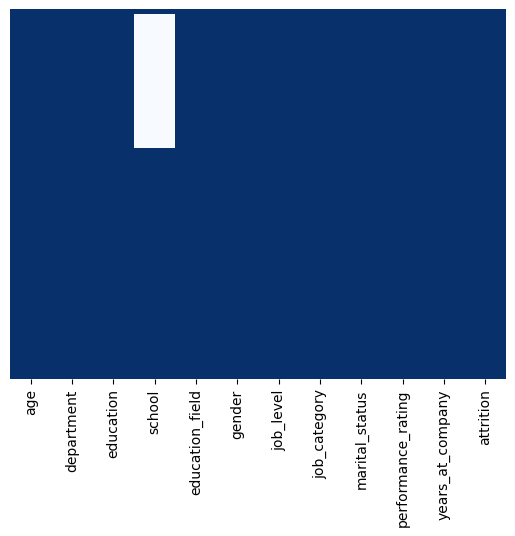

In [12]:
sns.heatmap(df.isnull(), cmap="Blues_r", cbar=False, yticklabels=False)

### 2.5 age

In [13]:
df["age"].describe()

count    5000.000000
mean       29.273800
std         4.876596
min        19.000000
25%        25.000000
50%        28.000000
75%        32.000000
max        54.000000
Name: age, dtype: float64

### 2.6 department

In [14]:
df["department"].describe()

count     4999
unique      57
top         FI
freq       651
Name: department, dtype: object

### 2.7 education

In [15]:
df["education"].describe()

count    5000.000000
mean        2.851800
std         0.509007
min         1.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: education, dtype: float64

## 3. Data cleaning

### 3.1 Data cleaning

In [16]:
# One hot encoding
cleaned_df = pd.get_dummies(df, columns=NO_ORDER_CATEGORICAL_FEATURES)

# Remove "employee_number"
cleaned_df = cleaned_df.iloc[:, 1:]

# Convert all boolean to integer
for col in cleaned_df.columns:
    if cleaned_df[col].dtype == np.bool_:
        cleaned_df[col] = cleaned_df[col].astype(int)

# Convert output
cleaned_df["attrition"] = cleaned_df["attrition"].map({"Yes": 1, "No": 0})

# Move output column to the last position
attrition_column = cleaned_df.pop("attrition")
cleaned_df = pd.concat([cleaned_df, attrition_column], axis=1)

cleaned_df

,education,job_level,performance_rating,years_at_company,department_AIC,department_CEP,department_DES,department_DPS,department_DXG,department_EBS,...,job_category_Others,job_category_PM,job_category_Product Engineering,job_category_QA,job_category_Tester,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown,attrition
0,3,4,3,3.169863,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,3,3,3,6.049315,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
2,3,4,4,4.254795,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,3,3,3,3.835616,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,3,3,3,3.002740,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3,3,3,0.041096,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4996,3,1,3,0.942466,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4997,3,1,3,1.372603,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4998,3,2,3,1.191781,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


### 3.2 Data standardization

### 3.3 Summary X and y

In [17]:
X_df = cleaned_df.iloc[:,:-1]
X_df

,education,job_level,performance_rating,years_at_company,department_AIC,department_CEP,department_DES,department_DPS,department_DXG,department_EBS,...,job_category_Manager,job_category_Others,job_category_PM,job_category_Product Engineering,job_category_QA,job_category_Tester,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown
0,3,4,3,3.169863,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,3,3,3,6.049315,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,3,4,4,4.254795,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,3,3,3.835616,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3,3,3,3.002740,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3,3,3,0.041096,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4996,3,1,3,0.942466,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4997,3,1,3,1.372603,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4998,3,2,3,1.191781,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [18]:
X = np.array(X_df).T
X

array([[3., 3., 3., ..., 3., 3., 3.],
       [4., 3., 4., ..., 1., 2., 2.],
       [3., 3., 4., ..., 3., 3., 3.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
X.shape

(358, 5000)

In [20]:
y_df = cleaned_df.iloc[:,-1]
y_df

0       1
1       1
2       1
3       1
4       1
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: attrition, Length: 5000, dtype: int64

In [21]:
y = np.array(y_df).reshape(-1, 1)
y

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [22]:
y.shape

(5000, 1)

### 3.4 Build Xbar (X and bias)

In [23]:
one = np.ones((1, X.shape[1]))
Xbar = np.concatenate((one, X), axis=0)
Xbar

array([[1., 1., 1., ..., 1., 1., 1.],
       [3., 3., 3., ..., 3., 3., 3.],
       [4., 3., 4., ..., 1., 2., 2.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
Xbar.shape

(359, 5000)

## 4. Build the models

### Requirements
- Neccessary features
- Best link functions

### 4.1. The simplest model

In [25]:
# y = f(w^Tx)

# f(s) = 1 / (1 + e^-s)     (logit link function)

In [26]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## 5. Algorithms optimization

### 5.1. Loss function selection

In [27]:
"""
z = b + w * x

y^ = 1 / (1 + e^-z) (sigmoid link function)

cost(y^, y) = -1 * (y * log(y^) + (1 - y) * log(1 - y^))

Conclusion: cost(y^, y) = 1/N * - (y^T * log(y^) + (1 - y)^T * log(1 - y^))

"""

'\nz = b + w * x\n\ny^ = 1 / (1 + e^-z) (sigmoid link function)\n\ncost(y^, y) = -1 * (y * log(y^) + (1 - y) * log(1 - y^))\n\nConclusion: cost(y^, y) = 1/N * - (y^T * log(y^) + (1 - y)^T * log(1 - y^))\n\n'

In [28]:
def cost(w: np.ndarray, Xbar: np.ndarray, y: np.ndarray):
    # w is a vector that includes the bias
    w = w.reshape(-1, 1)
    N = Xbar.shape[1]
    y_hat = sigmoid(Xbar.T.dot(w))
    epsilon = 1e-10
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon)  # Avoid log(0)
    return 1 / N * -(y.T.dot(np.log(y_hat)) + (1 - y).T.dot(np.log(1 - y_hat)))

In [29]:
"""
cost(y^, y) = 1/N * - (y * log(y^) + (y - 1) * log(1 - y^))

Let A = y * log(y^)

Let B = (y - 1) * log(1 - y^)


Find dA/dw

dA/dw 
= d(y * log(y^)) / dw
= y * 1 / y^ * (dy^/dw)
= y * 1 / y^ * (dy^/dz * dz/dw)
= y * 1 / y^ * ((1 - y^) * y^ * x)
= y * (1 - y^) * x


Find dB/dw

dB/dw
= d((1 - y) * log(1 - y^)) / dw
= (1 - y) / (1 - y^) * (dy^/dw)
= (1 - y) / (1 - y^) * (dy^/dz * dz/dw)
= (1 - y) / (1 - y^) * ((1 - y^) * y^ * x)
= (1 - y) * y^ * x

=> gradient(y^, y)
= dA/dw + dB/dw
= y * (1 - y^) * x + (1 - y) * y^ * x
= x * (y^ - y)

Conclusion: gradient(y^, y) = x^T * (y^ - y)

"""

'\ncost(y^, y) = 1/N * - (y * log(y^) + (y - 1) * log(1 - y^))\n\nLet A = y * log(y^)\n\nLet B = (y - 1) * log(1 - y^)\n\n\nFind dA/dw\n\ndA/dw \n= d(y * log(y^)) / dw\n= y * 1 / y^ * (dy^/dw)\n= y * 1 / y^ * (dy^/dz * dz/dw)\n= y * 1 / y^ * ((1 - y^) * y^ * x)\n= y * (1 - y^) * x\n\n\nFind dB/dw\n\ndB/dw\n= d((1 - y) * log(1 - y^)) / dw\n= (1 - y) / (1 - y^) * (dy^/dw)\n= (1 - y) / (1 - y^) * (dy^/dz * dz/dw)\n= (1 - y) / (1 - y^) * ((1 - y^) * y^ * x)\n= (1 - y) * y^ * x\n\n=> gradient(y^, y)\n= dA/dw + dB/dw\n= y * (1 - y^) * x + (1 - y) * y^ * x\n= x * (y^ - y)\n\nConclusion: gradient(y^, y) = x^T * (y^ - y)\n\n'

In [30]:
def grad(w: np.ndarray, Xbar: np.ndarray, y: np.ndarray):
    # w is a vector that includes the bias
    w = w.reshape(-1, 1)
    N = Xbar.shape[1]
    y_hat = sigmoid(Xbar.T.dot(w))
    epsilon = 1e-10
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon)  # Avoid log(0)
    return Xbar.dot(y_hat - y) / N

### 5.2. Double check gradient using numerical gradient

In [31]:
def check_grad(fn, gr, X, Xbar: np.ndarray, y: np.ndarray):
    # convert X to an 1d array, later we'll need only one for loop
    X_flat = X.ravel()
    shape_X = X.shape  # original shape of X
    num_grad = np.zeros_like(X)  # numerical grad, shape = shape of X
    grad_flat = np.zeros_like(X_flat)  # 1d version of grad
    eps = 1e-10  # a small number, 1e-10 -> 1e-6 is often good
    numElems = X_flat.shape[0]  # number of elements in X
    # calculate numerical gradient
    for i in range(numElems):  # iterate over all elements of X
        Xp_flat = X_flat.copy()
        Xn_flat = X_flat.copy()
        Xp_flat[i] += eps
        Xn_flat[i] -= eps
        Xp = Xp_flat.reshape(shape_X)
        Xn = Xn_flat.reshape(shape_X)
        fp_ = fn(Xp, Xbar, y)
        fn_ = fn(Xn, Xbar, y)
        grad_flat[i] = (fp_.item() - fn_.item()) / (2 * eps)

    num_grad = grad_flat.reshape(shape_X)

    diff = np.linalg.norm(num_grad.reshape(-1, 1) - gr(X, Xbar, y).reshape(-1, 1))
    print("Difference between two methods should be small:", diff)


# check_grad(cost, grad, np.array([0] * Xbar.shape[0]), Xbar, y)

In [32]:
# check_grad(cost, grad, np.array([0.1] * Xbar.shape[0]), Xbar, y)

check_grad(cost, grad, np.random.randn(Xbar.shape[0]), Xbar, y)

Difference between two methods should be small: 1.760146909066507e-05


### 5.3. Core functions

In [59]:
# Calculate the loss values along epoches
W_EPOCH = []
EPOCH_COUNT = []
LOSS_VALUE_EPOCH = []

# Calculate the loss values along time
W_TIME = []
TIME = []
LOSS_VALUE_TIME = []

RUNNING = threading.Event()


def reset_list():
    global W_EPOCH, EPOCH_COUNT, LOSS_VALUE_EPOCH, W_TIME, TIME, LOSS_VALUE_TIME

    W_EPOCH = []
    EPOCH_COUNT = []
    LOSS_VALUE_EPOCH = []

    W_TIME = []
    TIME = []
    LOSS_VALUE_TIME = []


class AlgorithmType(Enum):
    """Enumeration for different algorithm types with optional parameters."""

    # INCLUDED ADDITIONAL PARAMETERS

    # GRADIENT_DESCENT =================================================

    GRADIENT_DESCENT_FIX_LEARNING_RATE = {}
    """Gradient Descent with a fixed learning rate. No additional parameters."""

    GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE = {"alpha": 1 / 2, "beta": 1 / 4}
    """Gradient Descent with backtracking line search.
    
    Parameters:
    alpha: The fraction of the decrease in the function value. Range: (0.0, 1.0). Default: 0.5
    beta: The factor by which the step size is multiplied. Range: (0, 0.5]. Default: 0.25
    """

    # STOCHASTIC_GRADIENT_DESCENT ======================================

    STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE = {
        "batch_size": 1,
        "rule": 0,
        "random_seed": 10,
    }
    """Stochastic Gradient Descent with a diminishing learning rate.

    Parameters:
        batch_size: number of data points each training. Range: [0, N]. Default: 1
        rule: 0 is Randomized rule, 1 is Cyclic rule. Range: {0, 1}. Default: 0
        random_seed: Random number generator seed. Default: 10
    """

    STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE = {
        "batch_size": 1,
        "rule": 0,
        "random_seed": 10,
        "alpha": 1 / 2,
        "beta": 1 / 4,
    }
    """Stochastic Gradient Descent with a backtracking diminishing learning rate.

    Parameters:
        batch_size: number of data points each training. Range: [0, N]. Default: 1
        rule: 0 is Randomized rule, 1 is Cyclic rule. Range: {0, 1}. Default: 0
        random_seed: Random number generator seed. Default: 10
        alpha: The fraction of the decrease in the function value. Range: (0.0, 1.0). Default: 0.5
        beta: The factor by which the step size is multiplied. Range: (0, 0.5]. Default: 0.25
    """

    # MOMENTUM_GRADIENT_DESCENT ========================================

    MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE = {"gamma": 0.9}
    """Momentum Gradient Descent with a fixed learning rate.

    Parameters:
        gamma: weight of previous velocity.
    """

    MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE = {
        "gamma": 0.9,
        "alpha": 1 / 2,
        "beta": 1 / 4,
    }
    """Momentum Gradient Descent with backtracking line search.

    Parameters:
        gamma: Weight of previous velocity. Range: (0.0, 1.0). Default: 0.9
    """

    # NESTEROV_GRADIENT_DESCENT ========================================

    NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE = {"NAG_gamma": 0.9}
    """Nesterov Gradient Descent with a fixed learning rate.

    Parameters:
        gamma: Weight of previous velocity. Range: (0.0, 1.0). Default: 0.9
        alpha: The fraction of the decrease in the function value. Range: (0.0, 1.0). Default: 0.5
        beta: The factor by which the step size is multiplied. Range: (0, 0.5]. Default: 0.25
    """

    NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE = {
        "NAG_gamma": 0.9,
        "alpha": 1 / 2,
        "beta": 1 / 4,
    }
    """Nesterov Gradient Descent with backtracking line search.

    Parameters:
        gamma: Weight of previous velocity. Range: (0.0, 1.0). Default: 0.9
    """


# GRADIENT_DESCENT_FIX_LEARNING_RATE
def gradient_descent_fix_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    grad,
    w0: np.ndarray,
    learning_rate: np.float64,
    max_epochs=200,
    eps=1e-6,
):
    global W_EPOCH, EPOCH_COUNT, RUNNING

    RUNNING.set()

    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)
    W_EPOCH = [w0]

    EPOCH_COUNT = [1]
    for epoch in range(max_epochs):

        w_new = W_EPOCH[-1] - learning_rate * grad(W_EPOCH[-1], Xbar, y)

        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break

        W_EPOCH.append(w_new)
        EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)

    RUNNING.clear()


# GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
def gradient_descent_backtracking_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-6,
    additional_parameters=AlgorithmType.GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE.value,
    time_step=0.5,
):
    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)
    w = [w0]
    alpha = additional_parameters["alpha"]
    beta = additional_parameters["beta"]

    w_with_time = [w0]
    time_array = [0]
    start_time = time.time()

    epoch_count = [1]
    for epoch in range(max_epochs):

        learning_rate = initial_learning_rate

        # BACKTRACKING =================================================

        # At each iteration, start with lr = lr_init, and while
        #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||f(x)||_2^2 (squared of 2-norm)
        #           => t = beta * t
        # else
        # perform gradient descent update
        #           w_new = last_w - lr * grad(x)

        last_w = w[-1]
        left_hand_side = cost(last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y)
        right_hand_side = cost(
            last_w, Xbar, y
        ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

        while left_hand_side > right_hand_side:
            # Update learning rate
            learning_rate = beta * learning_rate

            left_hand_side = cost(
                last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
            )
            right_hand_side = cost(
                last_w, Xbar, y
            ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

        # ==============================================================

        w_new = w[-1] - learning_rate * grad(w[-1], Xbar, y)
        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break
        w.append(w_new)

        current_time = time.time()
        if current_time - start_time >= time_step:
            time_array.append(current_time - start_time)
            w_with_time.append(w[-1])

        epoch_count.append(epoch_count[-1] + 1)

    return w, time_array, w_with_time, epoch_count


# STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
def stochastic_gradient_descent_diminishing_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-6,
    additional_parameters=AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE.value,
    time_step=0.5,
):
    batch_size = (
        additional_parameters["batch_size"]
        if additional_parameters["batch_size"] > 0
        else 1
    )
    rule = (
        additional_parameters["rule"] if additional_parameters["rule"] in [0, 1] else 0
    )
    random_seed = additional_parameters["random_seed"]

    random.seed(random_seed)

    # Randomized rule
    if rule == 0:
        # w0 is a vector that included the bias
        w0 = w0.reshape(-1, 1)
        w = [w0]
        w_each_epoch = [w0]

        w_with_time = [w0]
        time_array = [0]
        start_time = time.time()

        epoch_count = [1]
        for epoch in range(max_epochs):
            all_indexes = list(range(Xbar.shape[1]))
            selected_indexes = []
            iteration = 0
            while len(all_indexes) > 0:
                iteration += 1

                if batch_size < len(all_indexes):
                    selected_indexes = random.sample(all_indexes, batch_size)
                else:
                    selected_indexes = all_indexes.copy()

                for index in selected_indexes:
                    all_indexes.remove(index)

                Xbar_batch = Xbar[:, selected_indexes]
                y_batch = y[selected_indexes]

                w_new = w[-1] - initial_learning_rate / iteration * grad(
                    w[-1], Xbar_batch, y_batch
                )
                w.append(w_new)

            w_each_epoch.append(w[-1])

            current_time = time.time()
            if current_time - start_time >= time_step:
                time_array.append(current_time - start_time)
                w_with_time.append(w[-1])

            if (
                np.linalg.norm(grad(w_each_epoch[-1], Xbar, y)) / np.array(w0).size
                < eps
            ):
                break

            epoch_count.append(epoch_count[-1] + 1)

        return w_each_epoch, time_array, w_with_time, epoch_count

    # Cyclic rule
    elif rule == 1:
        # w0 is a vector that included the bias
        w0 = w0.reshape(-1, 1)
        w = [w0]
        w_each_epoch = [w0]

        w_with_time = [w0]
        time_array = [0]
        start_time = time.time()

        epoch_count = [1]
        for epoch in range(max_epochs):
            all_indexes = list(range(Xbar.shape[1]))
            selected_indexes = []
            learning_rate = initial_learning_rate
            iteration = 0
            while len(all_indexes) > 0:
                iteration += 1
                if batch_size < len(all_indexes):
                    selected_indexes = all_indexes[:batch_size]
                else:
                    selected_indexes = all_indexes.copy()

                for index in selected_indexes:
                    all_indexes.remove(index)

                Xbar_batch = Xbar[:, selected_indexes]
                y_batch = y[selected_indexes]

                w_new = w[-1] - learning_rate / iteration * grad(
                    w[-1], Xbar_batch, y_batch
                )
                w.append(w_new)

            w_each_epoch.append(w[-1])

            current_time = time.time()
            if current_time - start_time >= time_step:
                time_array.append(current_time - start_time)
                w_with_time.append(w[-1])

            if (
                np.linalg.norm(grad(w_each_epoch[-1], Xbar, y)) / np.array(w0).size
                < eps
            ):
                break

            epoch_count.append(epoch_count[-1] + 1)

        return w_each_epoch, time_array, w_with_time, epoch_count

    # Invalid rule
    else:
        raise ValueError("'rule' must be 0 or 1.")


# STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE
def stochastic_gradient_descent_backtracking_diminishing_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-6,
    additional_parameters=AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE.value,
    time_step=0.5,
):
    batch_size = (
        additional_parameters["batch_size"]
        if additional_parameters["batch_size"] > 0
        else 1
    )
    rule = (
        additional_parameters["rule"] if additional_parameters["rule"] in [0, 1] else 0
    )
    random_seed = additional_parameters["random_seed"]
    alpha = additional_parameters["alpha"]
    beta = additional_parameters["beta"]

    random.seed(random_seed)

    # Randomized rule
    if rule == 0:
        # w0 is a vector that included the bias
        w0 = w0.reshape(-1, 1)
        w = [w0]
        w_each_epoch = [w0]

        w_with_time = [w0]
        time_array = [0]
        start_time = time.time()

        epoch_count = [1]
        for epoch in range(max_epochs):
            all_indexes = list(range(Xbar.shape[1]))
            selected_indexes = []
            iteration = 0
            while len(all_indexes) > 0:
                iteration += 1

                if batch_size < len(all_indexes):
                    selected_indexes = random.sample(all_indexes, batch_size)
                else:
                    selected_indexes = all_indexes.copy()

                for index in selected_indexes:
                    all_indexes.remove(index)

                Xbar_batch = Xbar[:, selected_indexes]
                y_batch = y[selected_indexes]

                learning_rate = initial_learning_rate / iteration

                # BACKTRACKING =================================================

                # At each iteration, start with lr = lr_init, and while
                #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||f(x)||_2^2 (squared of 2-norm)
                #           => t = beta * t
                # else
                # perform gradient descent update
                #           w_new = last_w - lr * grad(x)

                last_w = w[-1]
                left_hand_side = cost(
                    last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
                )
                right_hand_side = cost(
                    last_w, Xbar, y
                ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

                while left_hand_side > right_hand_side:
                    # Update learning rate
                    learning_rate = beta * learning_rate

                    left_hand_side = cost(
                        last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
                    )
                    right_hand_side = cost(
                        last_w, Xbar, y
                    ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

                # ==============================================================

                w_new = w[-1] - learning_rate * grad(w[-1], Xbar_batch, y_batch)
                w.append(w_new)

            w_each_epoch.append(w[-1])

            current_time = time.time()
            if current_time - start_time >= time_step:
                time_array.append(current_time - start_time)
                w_with_time.append(w[-1])

            if (
                np.linalg.norm(grad(w_each_epoch[-1], Xbar, y)) / np.array(w0).size
                < eps
            ):
                break

            epoch_count.append(epoch_count[-1] + 1)

        return w_each_epoch, time_array, w_with_time, epoch_count

    # Cyclic rule
    elif rule == 1:
        # w0 is a vector that included the bias
        w0 = w0.reshape(-1, 1)
        w = [w0]
        w_each_epoch = [w0]

        w_with_time = [w0]
        time_array = [0]
        start_time = time.time()

        epoch_count = [1]
        for epoch in range(max_epochs):
            all_indexes = list(range(Xbar.shape[1]))
            selected_indexes = []
            iteration = 0
            while len(all_indexes) > 0:
                iteration += 1
                if batch_size < len(all_indexes):
                    selected_indexes = all_indexes[:batch_size]
                else:
                    selected_indexes = all_indexes.copy()

                for index in selected_indexes:
                    all_indexes.remove(index)

                Xbar_batch = Xbar[:, selected_indexes]
                y_batch = y[selected_indexes]

                learning_rate = initial_learning_rate / iteration

                # BACKTRACKING =================================================

                # At each iteration, start with lr = lr_init, and while
                #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||f(x)||_2^2 (squared of 2-norm)
                #           => t = beta * t
                # else
                # perform gradient descent update
                #           w_new = last_w - lr * grad(x)

                last_w = w[-1]
                left_hand_side = cost(
                    last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
                )
                right_hand_side = cost(
                    last_w, Xbar, y
                ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

                while left_hand_side > right_hand_side:
                    # Update learning rate
                    learning_rate = beta * learning_rate

                    left_hand_side = cost(
                        last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
                    )
                    right_hand_side = cost(
                        last_w, Xbar, y
                    ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

                # ==============================================================

                w_new = w[-1] - learning_rate / iteration * grad(
                    w[-1], Xbar_batch, y_batch
                )
                w.append(w_new)

            w_each_epoch.append(w[-1])

            current_time = time.time()
            if current_time - start_time >= time_step:
                time_array.append(current_time - start_time)
                w_with_time.append(w[-1])

            if (
                np.linalg.norm(grad(w_each_epoch[-1], Xbar, y)) / np.array(w0).size
                < eps
            ):
                break

            epoch_count.append(epoch_count[-1] + 1)

        return w_each_epoch, time_array, w_with_time, epoch_count

    # Invalid rule
    else:
        raise ValueError("'rule' must be 0 or 1.")


# MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE
def momentum_gradient_descent_fix_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-6,
    additional_parameters=AlgorithmType.MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE.value,
    time_step=0.5,
):
    gamma = additional_parameters["gamma"]

    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)
    w = [w0]
    v_old = np.zeros_like(w0)

    w_with_time = [w0]
    time_array = [0]
    start_time = time.time()

    epoch_count = [1]
    for epoch in range(max_epochs):
        v_new = gamma * v_old + initial_learning_rate * grad(w[-1], Xbar, y)
        w_new = w[-1] - v_new
        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break
        w.append(w_new)
        v_old = v_new

        current_time = time.time()
        if current_time - start_time >= time_step:
            time_array.append(current_time - start_time)
            w_with_time.append(w[-1])

        epoch_count.append(epoch_count[-1] + 1)

    return w, time_array, w_with_time, epoch_count


# MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
def momentum_gradient_descent_backtracking_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-6,
    additional_parameters=AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE.value,
    time_step=0.5,
):
    gamma = additional_parameters["gamma"]
    alpha = additional_parameters["alpha"]
    beta = additional_parameters["beta"]

    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)
    w = [w0]
    v_old = np.zeros_like(w0)

    w_with_time = [w0]
    time_array = [0]
    start_time = time.time()

    epoch_count = [1]
    for epoch in range(max_epochs):
        # At each iteration, start with lr = lr_init, and while
        #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||f(x)||_2^2 (squared of 2-norm)
        #           => t = beta * t
        # else
        # perform gradient descent update
        #           w_new = last_w - lr * grad(x)

        last_w = w[-1]
        learning_rate = initial_learning_rate
        left_hand_side = cost(last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y)
        right_hand_side = cost(
            last_w, Xbar, y
        ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

        while left_hand_side > right_hand_side:
            # Update learning rate
            learning_rate = beta * learning_rate

            left_hand_side = cost(
                last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
            )
            right_hand_side = cost(
                last_w, Xbar, y
            ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

        v_new = gamma * v_old + learning_rate * grad(w[-1], Xbar, y)
        w_new = w[-1] - v_new
        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break
        w.append(w_new)
        v_old = v_new

        current_time = time.time()
        if current_time - start_time >= time_step:
            time_array.append(current_time - start_time)
            w_with_time.append(w[-1])

        epoch_count.append(epoch_count[-1] + 1)

    return w, time_array, w_with_time, epoch_count


# NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
def nesterov_gradient_descent_fix_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-6,
    additional_parameters=AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE.value,
    time_step=0.5,
):
    gamma = additional_parameters["NAG_gamma"]

    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)
    w = [w0]
    v = [np.zeros_like(w0)]

    w_with_time = [w0]
    time_array = [0]
    start_time = time.time()

    epoch_count = [1]
    for epoch in range(max_epochs):
        v_new = gamma * v[-1] + initial_learning_rate * grad(
            w[-1] - gamma * v[-1], Xbar, y
        )
        w_new = w[-1] - v_new
        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break
        w.append(w_new)
        v.append(v_new)

        current_time = time.time()
        if current_time - start_time >= time_step:
            time_array.append(current_time - start_time)
            w_with_time.append(w[-1])

        epoch_count.append(epoch_count[-1] + 1)

    return w, time_array, w_with_time, epoch_count


# NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
def nesterov_gradient_descent_backtracking_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-6,
    additional_parameters=AlgorithmType.NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE.value,
    time_step=0.5,
):
    gamma = additional_parameters["NAG_gamma"]
    alpha = additional_parameters["alpha"]
    beta = additional_parameters["beta"]

    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)
    w = [w0]
    v = [np.zeros_like(w0)]

    w_with_time = [w0]
    time_array = [0]
    start_time = time.time()

    epoch_count = [1]
    for epoch in range(max_epochs):
        # At each iteration, start with lr = lr_init, and while
        #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||f(x)||_2^2 (squared of 2-norm)
        #           => t = beta * t
        # else
        # perform gradient descent update
        #           w_new = last_w - lr * grad(x)

        last_w = w[-1]
        learning_rate = initial_learning_rate
        left_hand_side = cost(last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y)
        right_hand_side = cost(
            last_w, Xbar, y
        ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

        while left_hand_side > right_hand_side:
            # Update learning rate
            learning_rate = beta * learning_rate

            left_hand_side = cost(
                last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
            )
            right_hand_side = cost(
                last_w, Xbar, y
            ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

        v_new = gamma * v[-1] + learning_rate * grad(w[-1] - gamma * v[-1], Xbar, y)
        w_new = w[-1] - v_new
        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break
        w.append(w_new)
        v.append(v_new)

        current_time = time.time()
        if current_time - start_time >= time_step:
            time_array.append(current_time - start_time)
            w_with_time.append(w[-1])

        epoch_count.append(epoch_count[-1] + 1)

    return w, time_array, w_with_time, epoch_count


def calculate_loss_value(cost, w1: list, Xbar: np.ndarray, y: np.ndarray):
    loss_value = []
    for index in range(len(w1)):
        loss_value.append(cost(w1[index], Xbar, y).item())

    return loss_value


def snapshot_w(time_step: float):
    global W_TIME, TIME, RUNNING

    W_TIME = [W_EPOCH[0]]
    TIME = [0]

    start_time = time.time()
    last_time = time.time()
    current_time = time.time()

    while RUNNING.is_set():
        current_time = time.time()
        if current_time - last_time > time_step:
            W_TIME.append(W_EPOCH[-1])
            TIME.append(current_time - start_time)
            last_time = current_time


def plot(
    x: list,
    y: str,
    xlabel: str,
    ylabel: str,
    title: str,
):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


def one_for_all(
    algorithm_type: AlgorithmType,
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    initial_w: np.ndarray,
    initial_learning_rate: np.ndarray,
    algorithm_name: str,
    max_epochs=1000,
    eps=1e-6,
    additional_parameters=None,
    time_step=0.1,
):
    global W_EPOCH, EPOCH_COUNT, LOSS_VALUE_EPOCH, W_TIME, TIME, LOSS_VALUE_TIME

    match algorithm_type:

        case AlgorithmType.GRADIENT_DESCENT_FIX_LEARNING_RATE:
            calculating_thread = threading.Thread(
                target=gradient_descent_fix_learning_rate,
                args=(
                    Xbar,
                    y,
                    grad,
                    initial_w,
                    initial_learning_rate,
                    max_epochs,
                    eps,
                ),
            )

        case AlgorithmType.GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE:
            w1, time_array, w_tith_time, epoch_count = (
                gradient_descent_backtracking_learning_rate(
                    Xbar,
                    y,
                    grad,
                    initial_w,
                    initial_learning_rate,
                    max_epochs,
                    eps,
                    additional_parameters,
                    time_step,
                )
            )

        case AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE:
            w1, time_array, w_tith_time, epoch_count = (
                stochastic_gradient_descent_diminishing_learning_rate(
                    Xbar,
                    y,
                    grad,
                    initial_w,
                    initial_learning_rate,
                    max_epochs,
                    eps,
                    additional_parameters,
                    time_step,
                )
            )

        case AlgorithmType.MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE:
            w1, time_array, w_tith_time, epoch_count = (
                momentum_gradient_descent_fix_learning_rate(
                    Xbar,
                    y,
                    grad,
                    initial_w,
                    initial_learning_rate,
                    max_epochs,
                    eps,
                    additional_parameters,
                    time_step,
                )
            )

        case AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE:
            w1, time_array, w_tith_time, epoch_count = (
                momentum_gradient_descent_backtracking_learning_rate(
                    Xbar,
                    y,
                    grad,
                    initial_w,
                    initial_learning_rate,
                    max_epochs,
                    eps,
                    additional_parameters,
                    time_step,
                )
            )

        case AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE:
            w1, time_array, w_tith_time, epoch_count = (
                nesterov_gradient_descent_fix_learning_rate(
                    Xbar,
                    y,
                    grad,
                    initial_w,
                    initial_learning_rate,
                    max_epochs,
                    eps,
                    additional_parameters,
                    time_step,
                )
            )

        case AlgorithmType.NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE:
            w1, time_array, w_tith_time, epoch_count = (
                nesterov_gradient_descent_backtracking_learning_rate(
                    Xbar,
                    y,
                    grad,
                    initial_w,
                    initial_learning_rate,
                    max_epochs,
                    eps,
                    additional_parameters,
                    time_step,
                )
            )

    timing_thread = threading.Thread(target=snapshot_w, args=(time_step,))

    reset_list()

    calculating_thread.start()
    timing_thread.start()

    calculating_thread.join()
    timing_thread.join()

    LOSS_VALUE_EPOCH = calculate_loss_value(cost, W_EPOCH, Xbar, y)

    LOSS_VALUE_TIME = calculate_loss_value(cost, W_TIME, Xbar, y)

    print(f"{algorithm_name}")
    print(f"Best loss values: {LOSS_VALUE_EPOCH[-1]:.6f}")
    print(f"Initial learning rate: {initial_learning_rate}")
    print(f"Runtime: {TIME[-1]:.6f} seconds")
    print(f"Additional parameters: {additional_parameters}")

    plot(
        EPOCH_COUNT,
        LOSS_VALUE_EPOCH,
        "Epoches",
        "Loss values",
        f"{algorithm_type} | LOSS_VALUE along EPOCHES",
    )

    plot(
        TIME,
        LOSS_VALUE_TIME,
        "Time (seconds)",
        "Loss values",
        f"{algorithm_type} | LOSS_VALUE along TIME",
    )

    return (EPOCH_COUNT, LOSS_VALUE_EPOCH, TIME, LOSS_VALUE_TIME)

In [60]:
class Result:
    def __init__(self):
        pass

    def add_parameter(
        self,
        algorithm_type: AlgorithmType,
        initial_w: np.ndarray,
        initial_learning_rate: np.ndarray,
        max_epochs: int = 1000,
        eps: float = 1e-6,
        additional_parameters: dict = {},
    ):
        self.algorithm_type = algorithm_type.name
        self.initial_w = initial_w
        self.initial_learning_rate = initial_learning_rate
        self.max_epochs = max_epochs
        self.eps = eps
        self.additional_parameters = additional_parameters

    def add_one_for_all_result(self, one_for_all_result):
        self.epoch_count = one_for_all_result[0]
        self.loss_value_epoch = one_for_all_result[1]
        self.time = one_for_all_result[2]
        self.loss_value_epoch = one_for_all_result[3]


class ResultSet:
    def __init__(self):
        self.list_result: list[Result] = []

    def add_result(self, result: Result):
        result.id = len(self.list_result) + 1
        self.list_result.append(result)

In [66]:
result_set = ResultSet()

### 5.4. GRADIENT_DESCENT_FIX_LEARNING_RATE

GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss values: 0.475599
Initial learning rate: 0.1
Runtime: 31.895167 seconds
Additional parameters: None


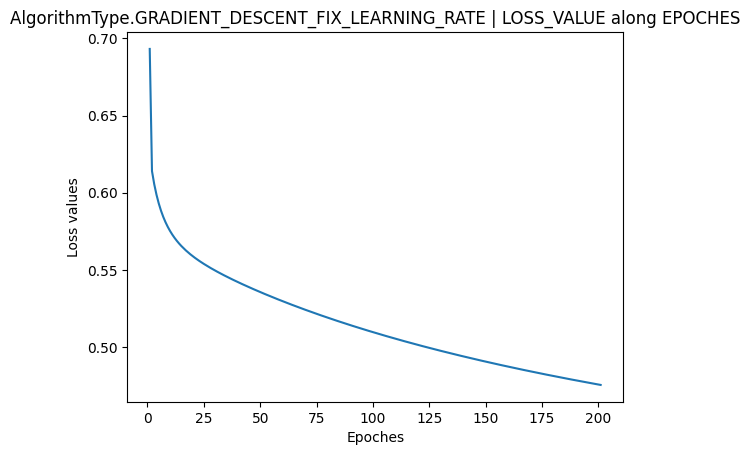

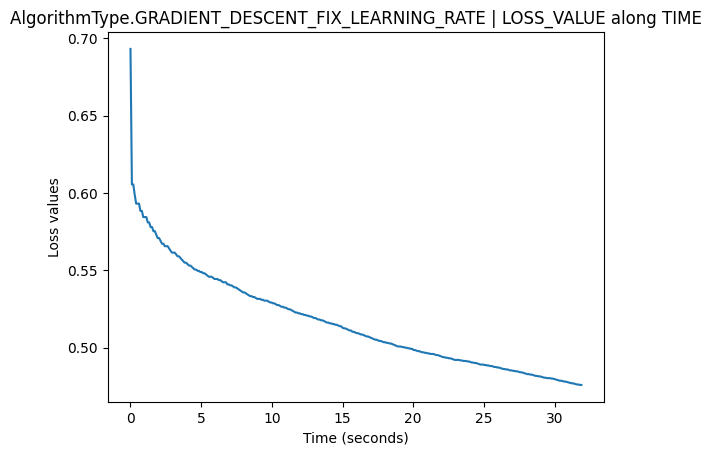

In [61]:
ALGORITHM_TYPE = AlgorithmType.GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 0.1
MAX_EPOCHS = 200
EPS = 1e-6

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        eps=EPS,
    )
)

GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.350942
Initial learning rate: 1
Additional parameters: None
Runtime: 2.117927 s


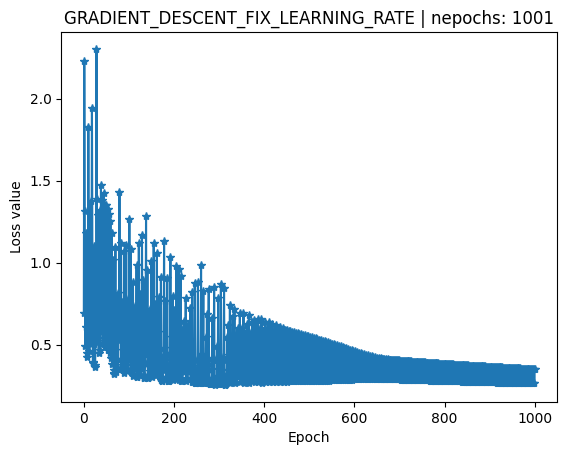

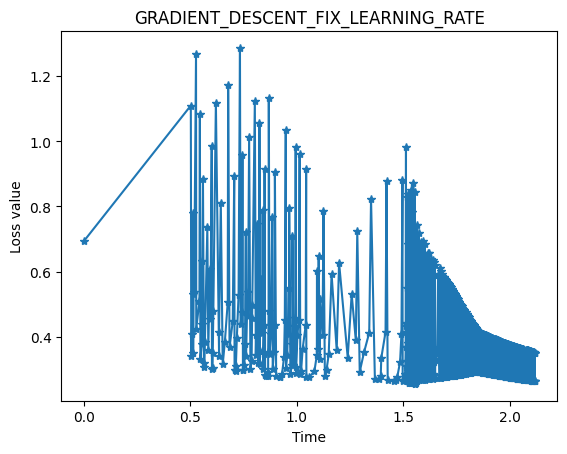

GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.236563
Initial learning rate: 0.5
Additional parameters: None
Runtime: 3.035619 s


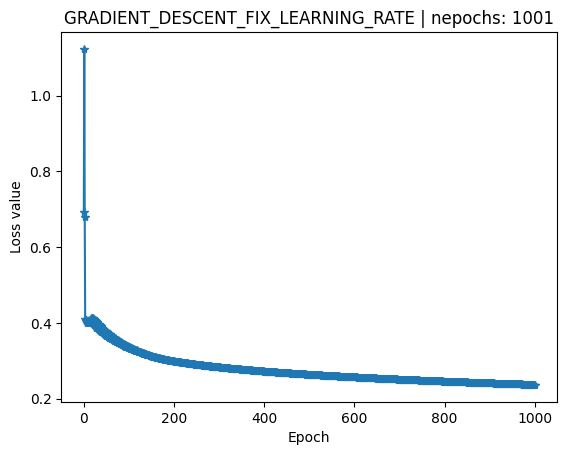

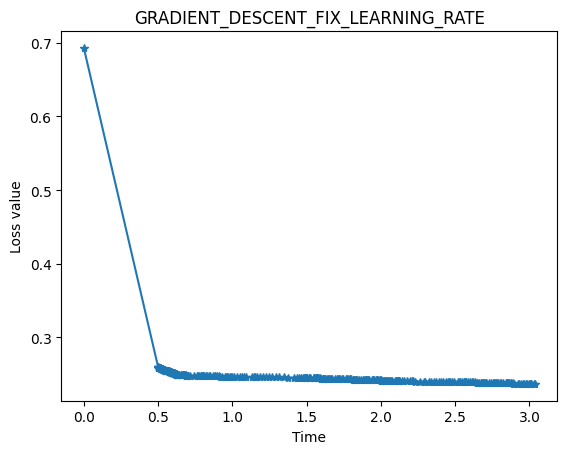

GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.240809
Initial learning rate: 0.45
Additional parameters: None
Runtime: 13.429889 s


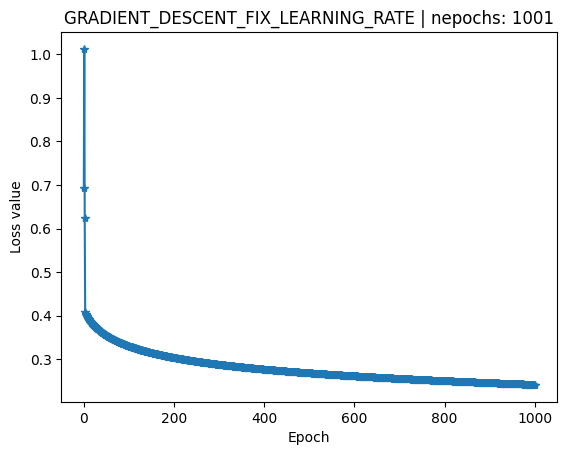

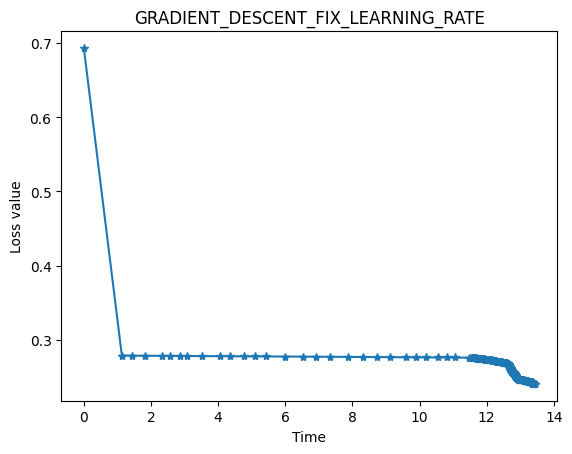

GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.272104
Initial learning rate: 0.2
Additional parameters: None
Runtime: 0.973583 s


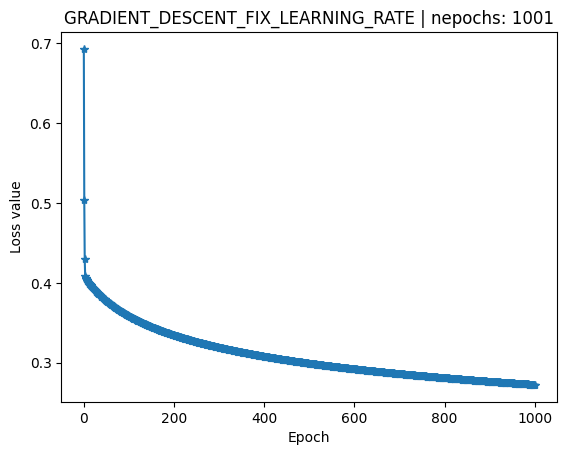

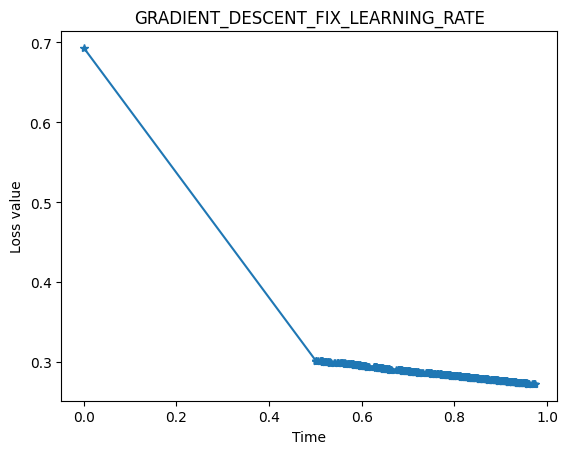

GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.325882
Initial learning rate: 0.05
Additional parameters: None
Runtime: 1.576739 s


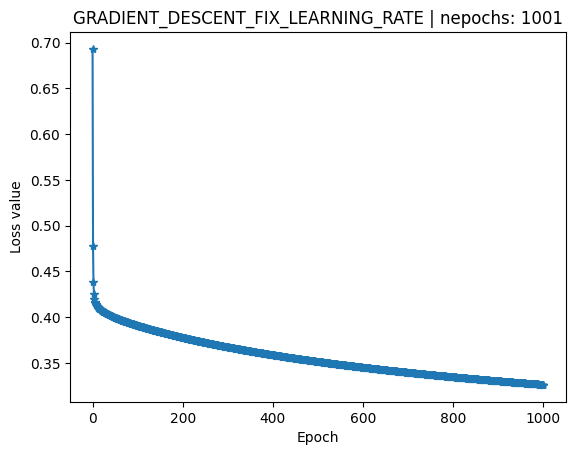

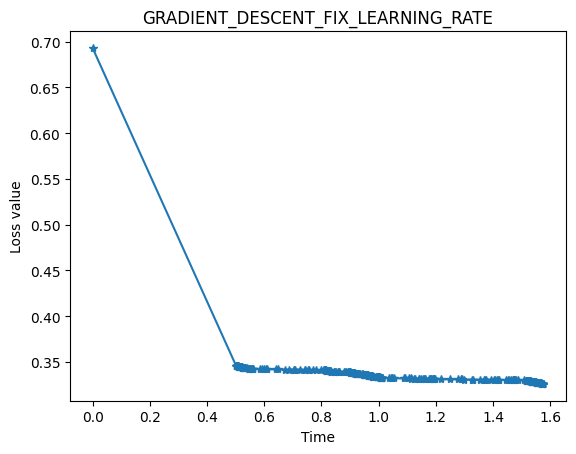

In [143]:
# Test GD với fix learning rate


ALGORITHM_TYPE = AlgorithmType.GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = [1, 0.5, 0.45, 0.2, 0.05]
MAX_EPOCHS = 1000
EPS = 1e-6


# ADDITIONAL PARAMETERS
ALGORITHM_TYPE.value

for i in range(len(INITIAL_LEARNING_RATE)):
    (
        GRADIENT_DESCENT_FIX_LEARNING_RATE_w,
        GRADIENT_DESCENT_FIX_LEARNING_RATE_loss_value,
        GRADIENT_DESCENT_FIX_LEARNING_RATE_time_array,
        GRADIENT_DESCENT_FIX_LEARNING_RATE_w_tith_time,
    ) = one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE[i],
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        eps=EPS,
        marker="*",
    )

### 5.5. GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE

In [155]:
ALGORITHM_TYPE = AlgorithmType.GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 200
EPS = 1e-6

ALPHA = 0.5
BETA = 0.8


# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

(
    GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w,
    GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_loss_value,
    GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_time_array,
    GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w_tith_time,
) = one_for_all(
    algorithm_type=ALGORITHM_TYPE,
    Xbar=Xbar,
    y=y,
    cost=cost,
    grad=grad,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    algorithm_name=ALGORITHM_TYPE.name,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    marker="*",
    additional_parameters=ADDITIONAL_PARAMETERS,
)

KeyboardInterrupt: 

GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Best loss function value: 0.557014
Initial learning rate: 1
Additional parameters: {'alpha': 0.1, 'beta': 0.7}
Runtime: 62.547830 s


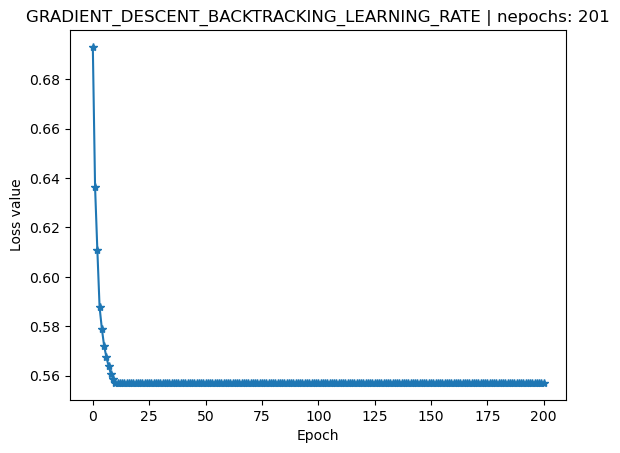

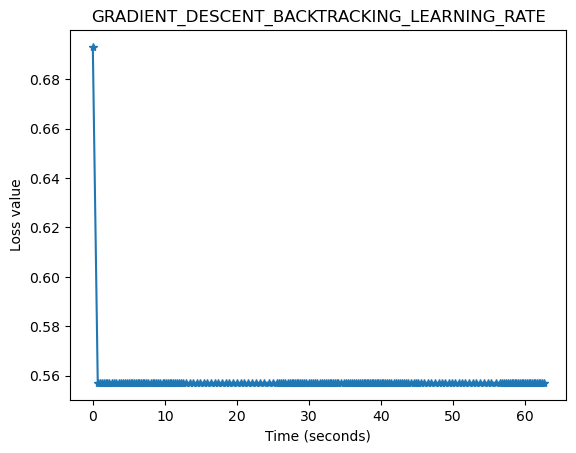

GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Best loss function value: 0.599681
Initial learning rate: 1
Additional parameters: {'alpha': 0.3, 'beta': 0.8}
Runtime: 123.436026 s


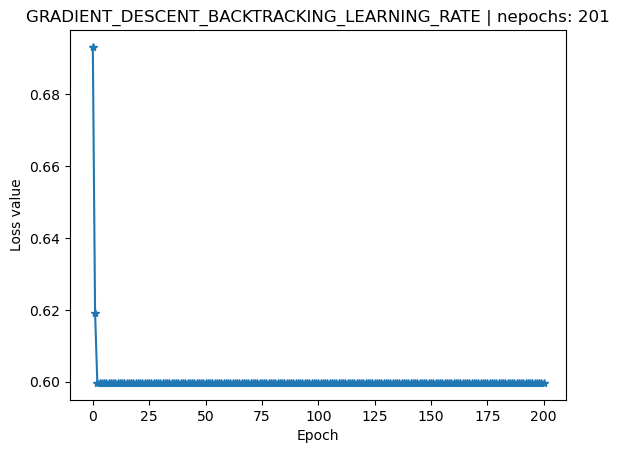

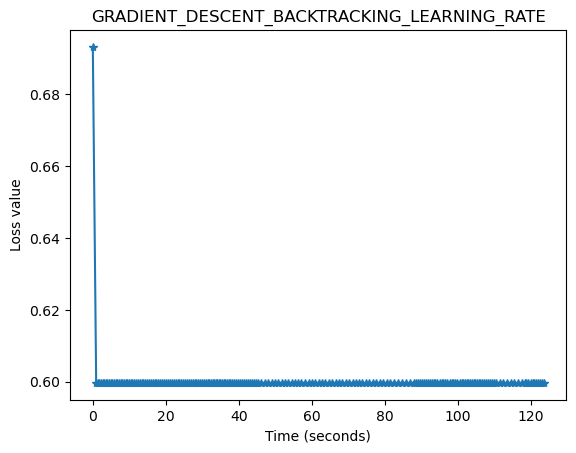

GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Best loss function value: 0.615703
Initial learning rate: 1
Additional parameters: {'alpha': 0.5, 'beta': 0.9}
Runtime: 208.055417 s


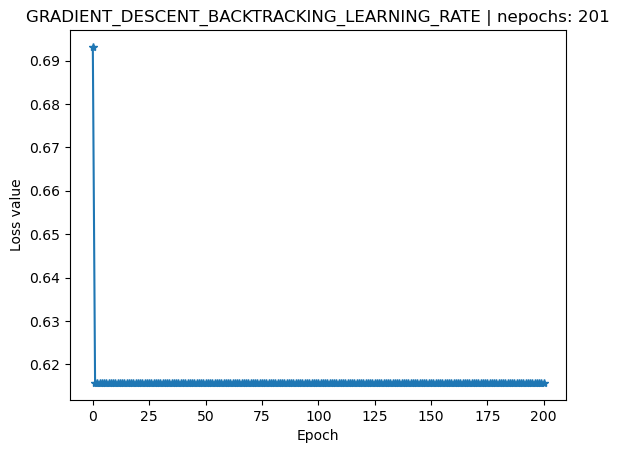

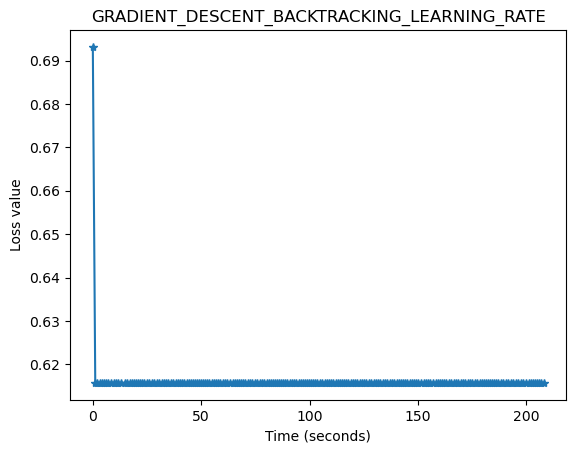

In [67]:
## Test GD backtracking

ALGORITHM_TYPE = AlgorithmType.GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 200
EPS = 1e-6

parameter_sets = [
    {"ALPHA": 0.1, "BETA": 0.7},
    {"ALPHA": 0.3, "BETA": 0.8},
    {"ALPHA": 0.5, "BETA": 0.9},
]


for params in parameter_sets:
    ALPHA = params["ALPHA"]
    BETA = params["BETA"]

    # ADDITIONAL PARAMETERS
    ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value
    ADDITIONAL_PARAMETERS["alpha"] = ALPHA
    ADDITIONAL_PARAMETERS["beta"] = BETA

    (
        GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w,
        GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_loss_value,
        GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_time_array,
        GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w_tith_time,
    ) = one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        eps=EPS,
        marker="*",
        additional_parameters=ADDITIONAL_PARAMETERS,
    )

### 5.6. STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE - randomized

AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.056314
Initial learning rate: 0.03
Additional parameters: {'batch_size': 1, 'rule': 0, 'random_seed': 10}
Runtime: 204.393667 s


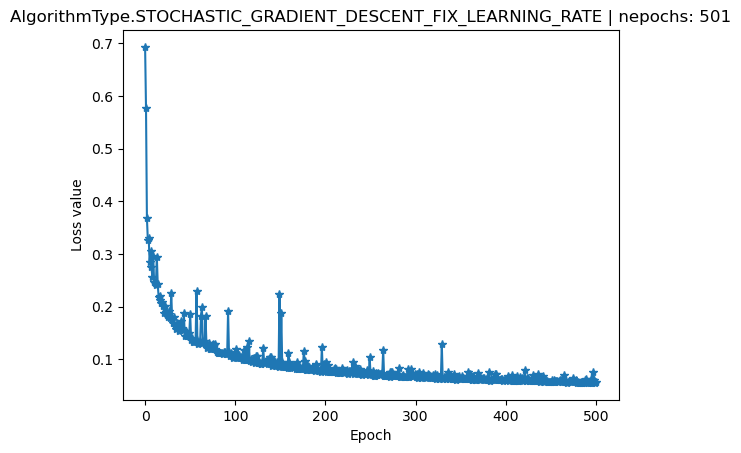

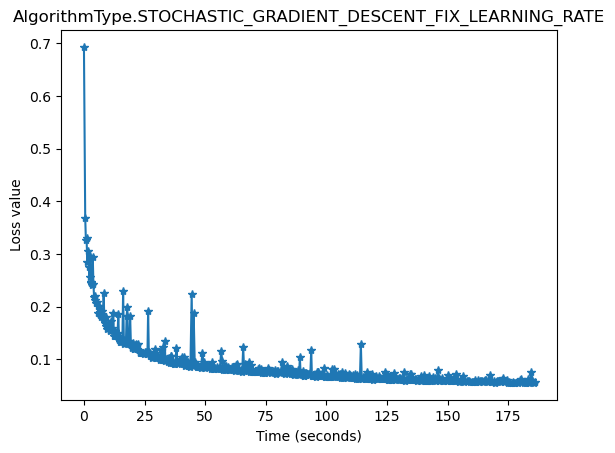

In [102]:
ALGORITHM_TYPE = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 0.03
MAX_EPOCHS = 500
EPS = 1e-6

BATCH_SIZE = 1
RULE = 0
RANDOM_SEED = 10


# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED

(
    STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_w,
    STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_loss_value,
    STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_time_array,
    STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_w_tith_time,
) = one_for_all(
    algorithm_type=ALGORITHM_TYPE,
    Xbar=Xbar,
    y=y,
    cost=cost,
    grad=grad,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    algorithm_name=ALGORITHM_TYPE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    marker="*",
    additional_parameters=ADDITIONAL_PARAMETERS,
)

AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 1.114753
Initial learning rate: 1
Additional parameters: {'batch_size': 1, 'rule': 1, 'random_seed': 10}
Runtime: 142.910018 s


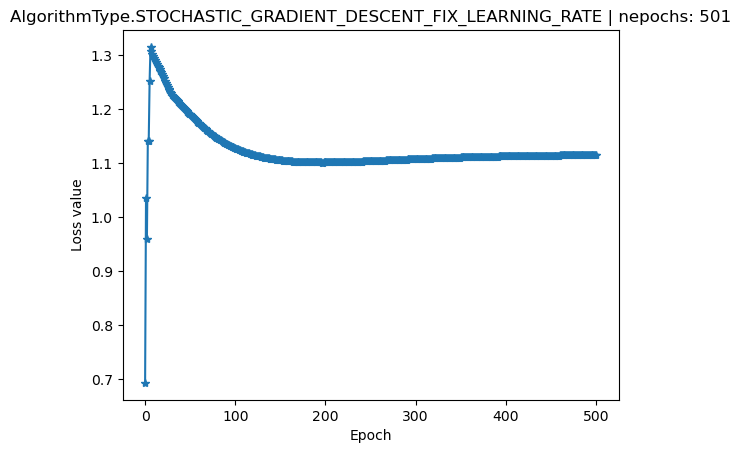

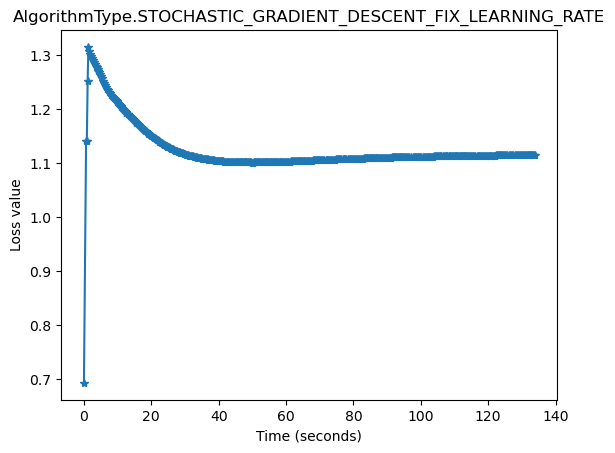

ValueError: too many values to unpack (expected 2)

In [68]:
ALGORITHM_TYPE = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
# INITIAL_LEARNING_RATE = 0.01
MAX_EPOCHS = 500
EPS = 1e-6

# BATCH_SIZE = 1
RULE = 0
RANDOM_SEED = 10
learning_rates = [1, 0.01, 0.1]
batch_sizes = [1, 10, 50]


for lr in learning_rates:
    for batch_size in batch_sizes:
        ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

        ADDITIONAL_PARAMETERS["batch_size"] = batch_size
        ADDITIONAL_PARAMETERS["rule"] = RULE
        ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED

        (
            STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_w,
            STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_loss_value,
            STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_time_array,
            STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_w_tith_time,
        ) = one_for_all(
            algorithm_type=ALGORITHM_TYPE,
            Xbar=Xbar,
            y=y,
            cost=cost,
            grad=grad,
            initial_w=INITIAL_W,
            initial_learning_rate=lr,
            algorithm_name=ALGORITHM_TYPE,
            max_epochs=MAX_EPOCHS,
            eps=EPS,
            marker="*",
            additional_parameters=ADDITIONAL_PARAMETERS,
        )

### 5.7. STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE - cyclic

AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 1.114753
Initial learning rate: 1
Additional parameters: {'batch_size': 1, 'rule': 1, 'random_seed': 10}
Runtime: 159.971653 s


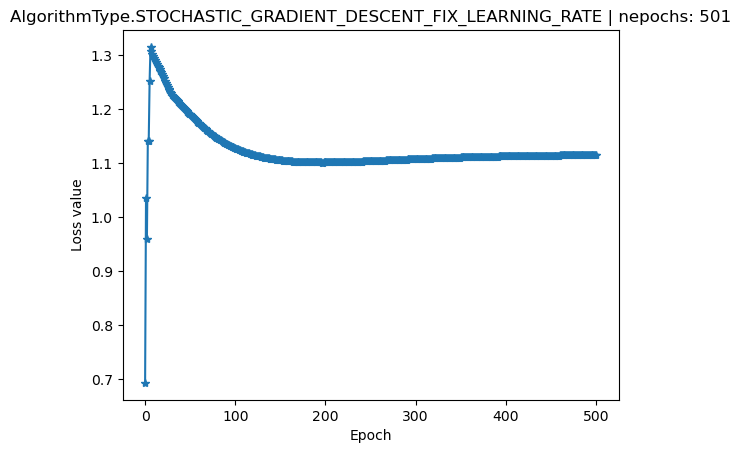

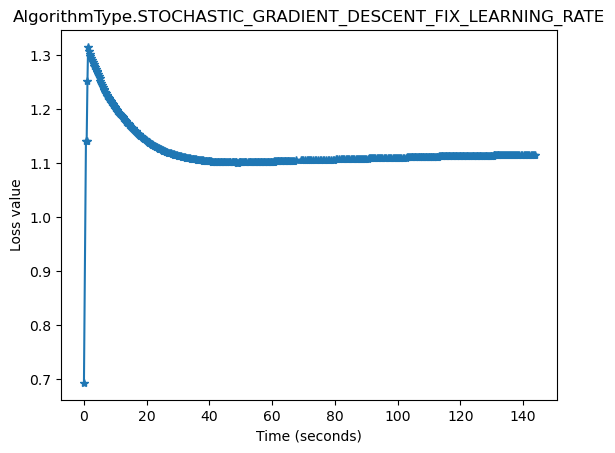

In [104]:
ALGORITHM_TYPE = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 500
EPS = 1e-6

BATCH_SIZE = 1
RULE = 1
RANDOM_SEED = 10


# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED

(
    STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_w,
    STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_loss_value,
    STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_time_array,
    STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_w_tith_time,
) = one_for_all(
    algorithm_type=ALGORITHM_TYPE,
    Xbar=Xbar,
    y=y,
    cost=cost,
    grad=grad,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    algorithm_name=ALGORITHM_TYPE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    marker="*",
    additional_parameters=ADDITIONAL_PARAMETERS,
)

AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.745801
Initial learning rate: 0.5
Additional parameters: {'batch_size': 1, 'rule': 1, 'random_seed': 10}
Runtime: 164.618860 s


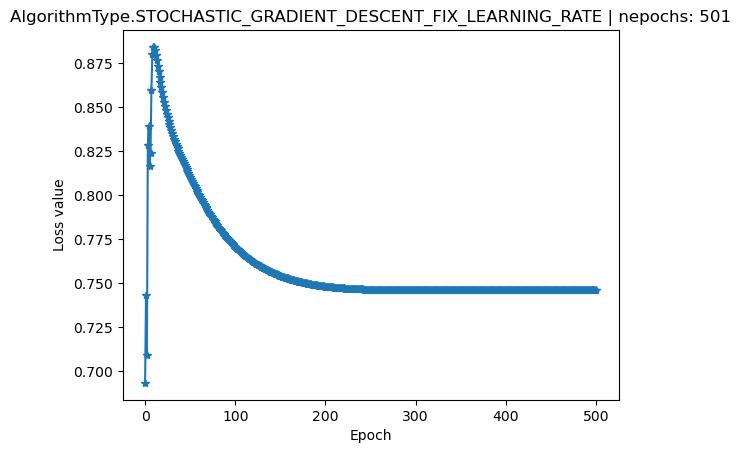

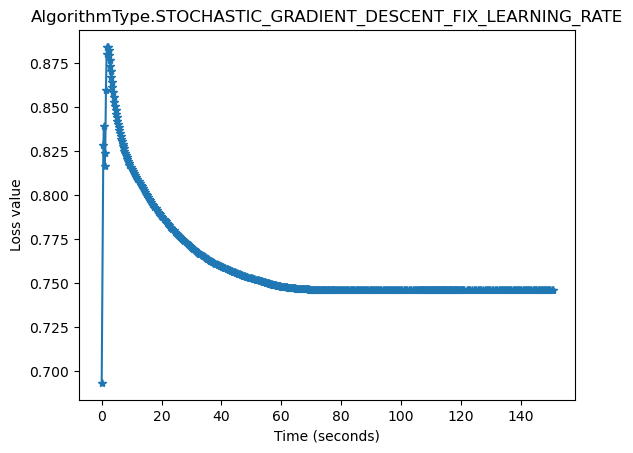

AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.738663
Initial learning rate: 0.5
Additional parameters: {'batch_size': 5, 'rule': 1, 'random_seed': 10}
Runtime: 52.237559 s


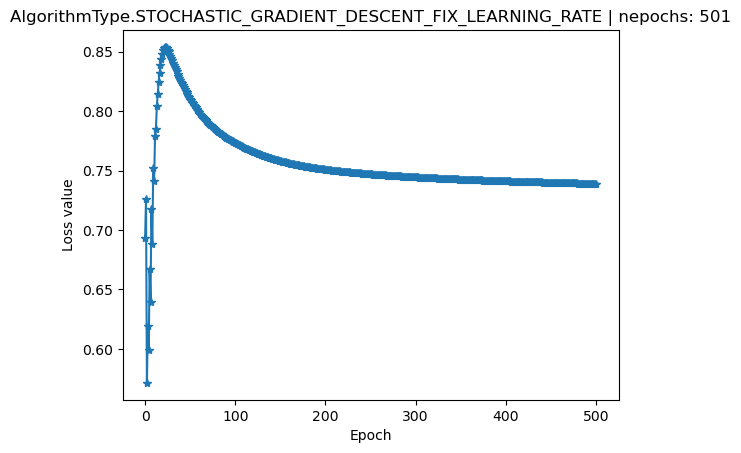

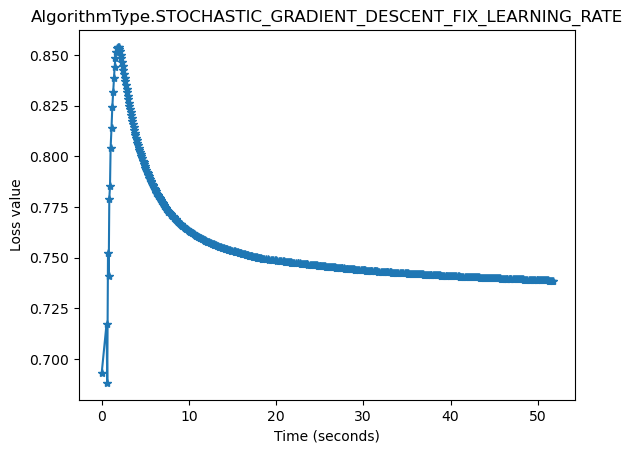

AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.731639
Initial learning rate: 0.5
Additional parameters: {'batch_size': 10, 'rule': 1, 'random_seed': 10}
Runtime: 35.847077 s


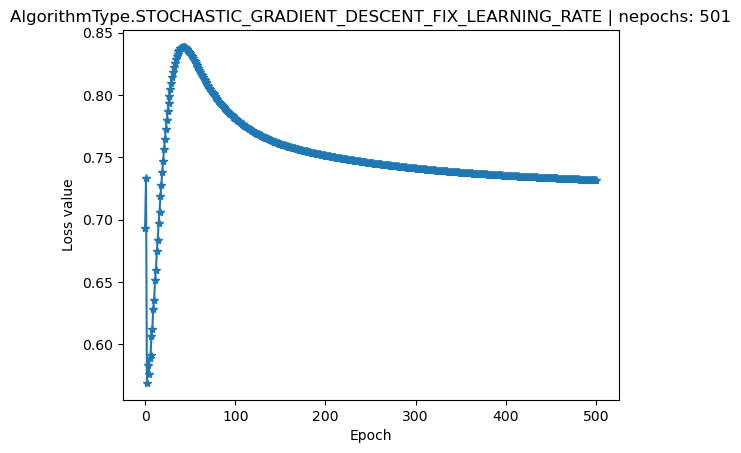

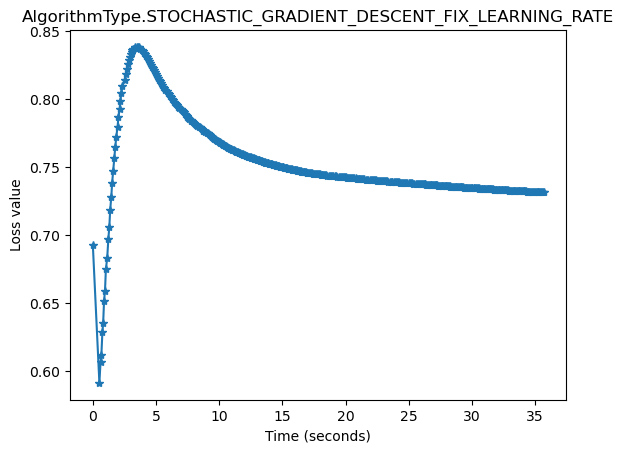

AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.966329
Initial learning rate: 0.5
Additional parameters: {'batch_size': 50, 'rule': 1, 'random_seed': 10}
Runtime: 28.906282 s


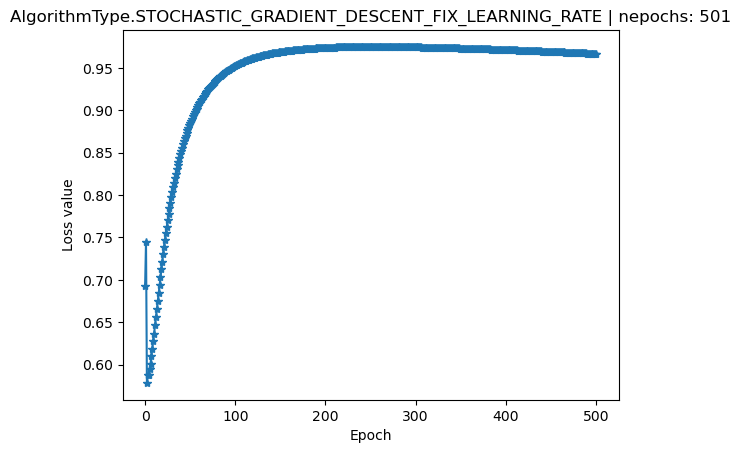

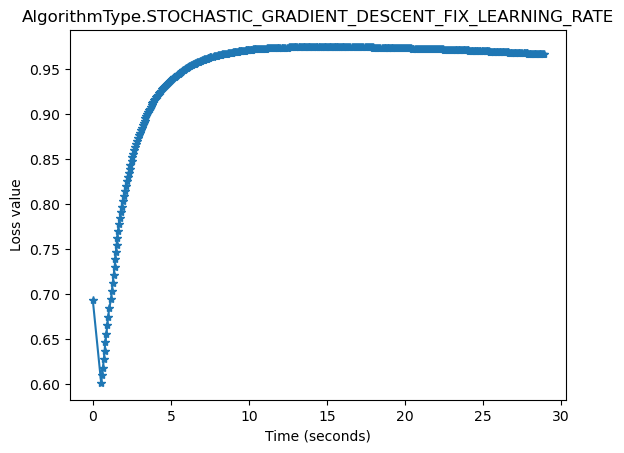

KeyboardInterrupt: 

In [103]:
ALGORITHM_TYPE = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = [0.5, 1]
MAX_EPOCHS = 500
EPS = 1e-6

BATCH_SIZE = [1, 5, 10, 50]
RULE = 1
RANDOM_SEED = 10

for lr in INITIAL_LEARNING_RATE:
    for bs in BATCH_SIZE:
        # ADDITIONAL PARAMETERS
        ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

        ADDITIONAL_PARAMETERS["batch_size"] = bs
        ADDITIONAL_PARAMETERS["rule"] = RULE
        ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED

        (
            STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_w,
            STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_loss_value,
            STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_time_array,
            STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_w_tith_time,
        ) = one_for_all(
            algorithm_type=ALGORITHM_TYPE,
            Xbar=Xbar,
            y=y,
            cost=cost,
            grad=grad,
            initial_w=INITIAL_W,
            initial_learning_rate=lr,
            algorithm_name=ALGORITHM_TYPE,
            max_epochs=MAX_EPOCHS,
            eps=EPS,
            marker="*",
            additional_parameters=ADDITIONAL_PARAMETERS,
        )

### 5.8. MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE

AlgorithmType.MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.127803
Initial learning rate: 1
Additional parameters: {'gamma': 0.9}
Runtime: 2.567415 s


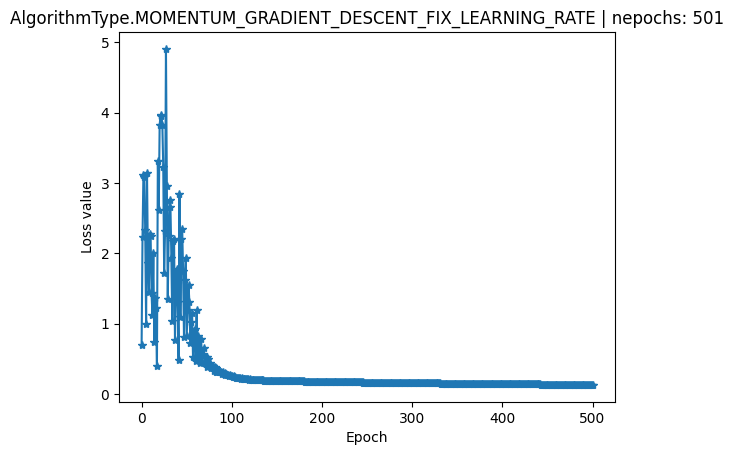

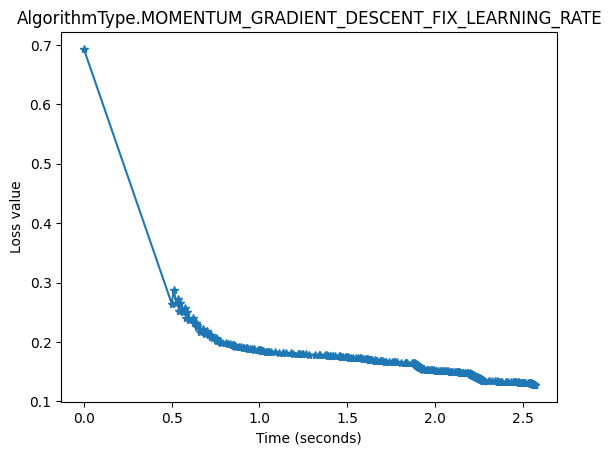

In [176]:
ALGORITHM_TYPE = AlgorithmType.MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 500
EPS = 1e-6

GAMMA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["gamma"] = GAMMA

(
    MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_w,
    MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_loss_value,
    MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_time_array,
    MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_epoch_count,
) = one_for_all(
    algorithm_type=ALGORITHM_TYPE,
    Xbar=Xbar,
    y=y,
    cost=cost,
    grad=grad,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    algorithm_name=ALGORITHM_TYPE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    marker="*",
    additional_parameters=ADDITIONAL_PARAMETERS,
)

AlgorithmType.MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.388998
Initial learning rate: 0.1
Additional parameters: {'gamma': 0.5}
Runtime: 1.090453 s


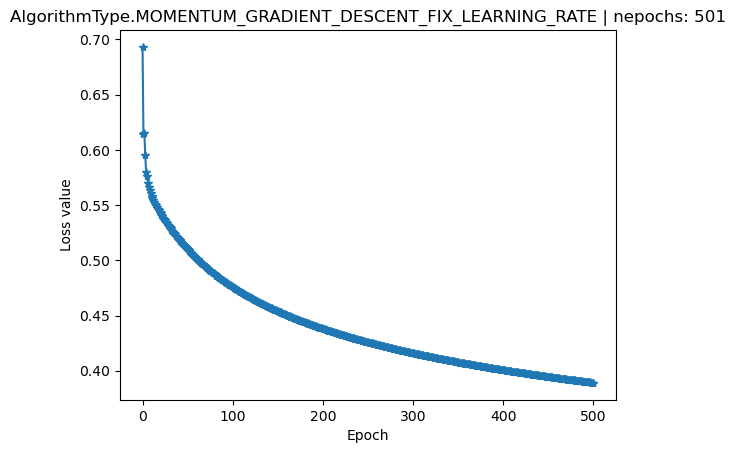

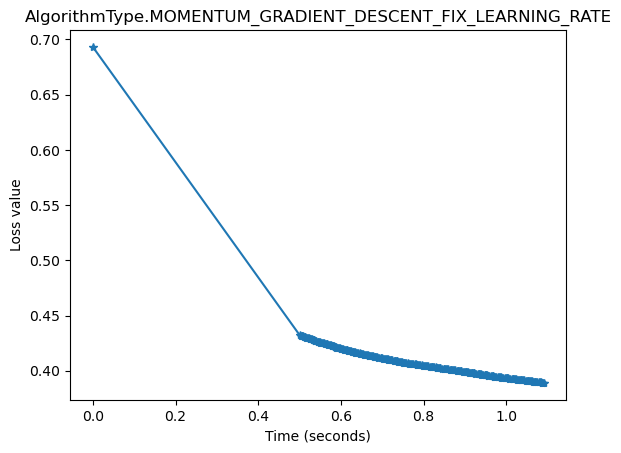

ValueError: too many values to unpack (expected 2)

In [73]:
learning_rates = [0.1, 1, 0.5, 0.01]
gammas = [0.5, 0.9, 0.2]

ALGORITHM_TYPE = AlgorithmType.MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
# INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 500
EPS = 1e-6

for lr in learning_rates:
    for gamma in gammas:
        ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

        ADDITIONAL_PARAMETERS["gamma"] = gamma

        (
            MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_w,
            MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_loss_value,
            MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_time_array,
            MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_w_tith_time,
        ) = one_for_all(
            algorithm_type=ALGORITHM_TYPE,
            Xbar=Xbar,
            y=y,
            cost=cost,
            grad=grad,
            initial_w=INITIAL_W,
            initial_learning_rate=lr,
            algorithm_name=ALGORITHM_TYPE,
            max_epochs=MAX_EPOCHS,
            eps=EPS,
            marker="*",
            additional_parameters=ADDITIONAL_PARAMETERS,
        )

### 5.9. MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE

AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Best loss function value: 0.564613
Initial learning rate: 1
Additional parameters: {'gamma': 0.6, 'alpha': 0.3, 'beta': 0.5}
Runtime: 77.540143 s


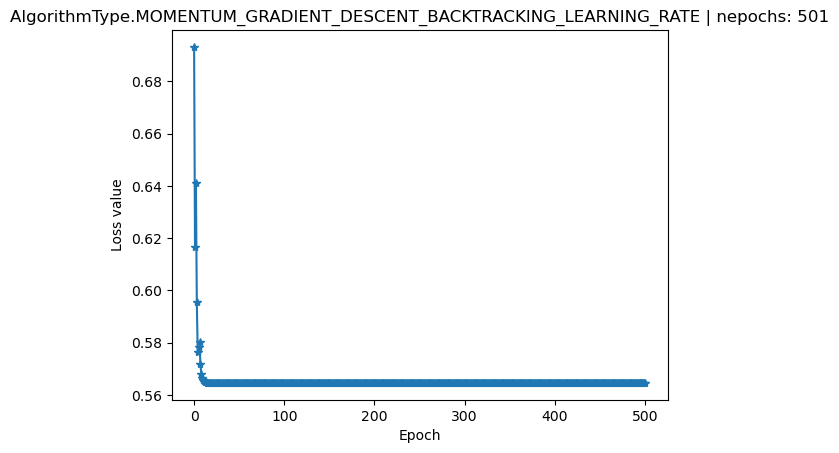

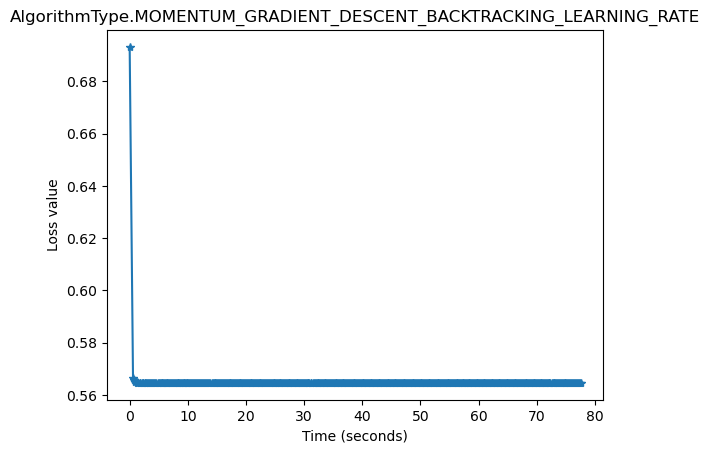

In [72]:
ALGORITHM_TYPE = AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 500
EPS = 1e-6

GAMMA = 0.6
ALPHA = 0.3
BETA = 0.5

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["gamma"] = GAMMA
ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

(
    MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w,
    MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE__loss_value,
    MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_time_array,
    MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w_tith_time,
) = one_for_all(
    algorithm_type=ALGORITHM_TYPE,
    Xbar=Xbar,
    y=y,
    cost=cost,
    grad=grad,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    algorithm_name=ALGORITHM_TYPE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    marker="*",
    additional_parameters=ADDITIONAL_PARAMETERS,
)

AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Best loss function value: 0.477902
Initial learning rate: 1
Additional parameters: {'gamma': 0.9, 'alpha': 0.3, 'beta': 0.8}
Runtime: 262.575588 s


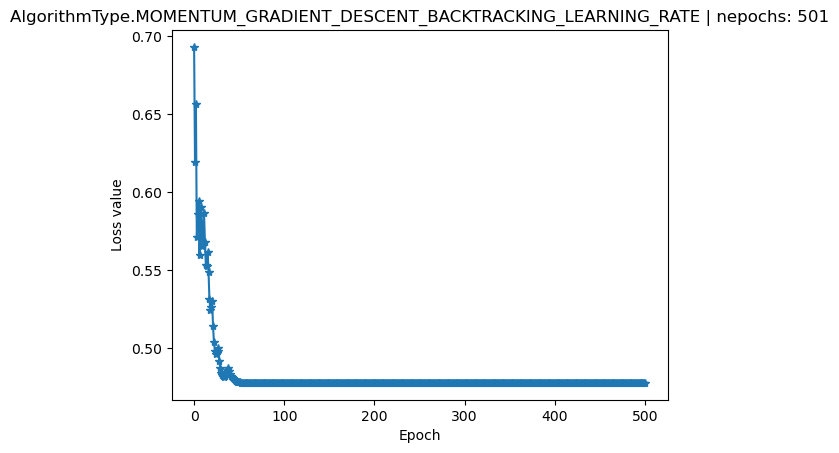

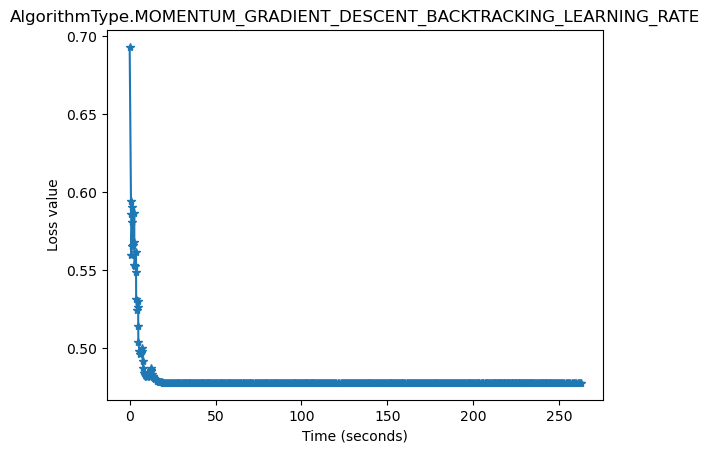

AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Best loss function value: 0.479570
Initial learning rate: 1.5
Additional parameters: {'gamma': 0.9, 'alpha': 0.3, 'beta': 0.8}
Runtime: 281.539462 s


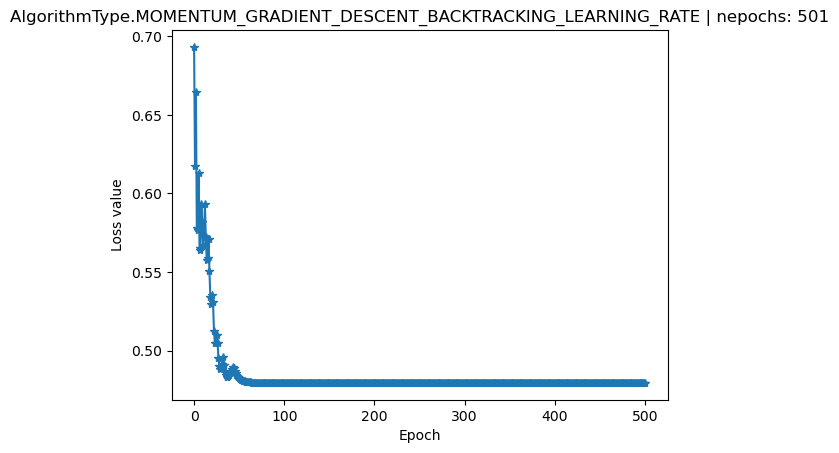

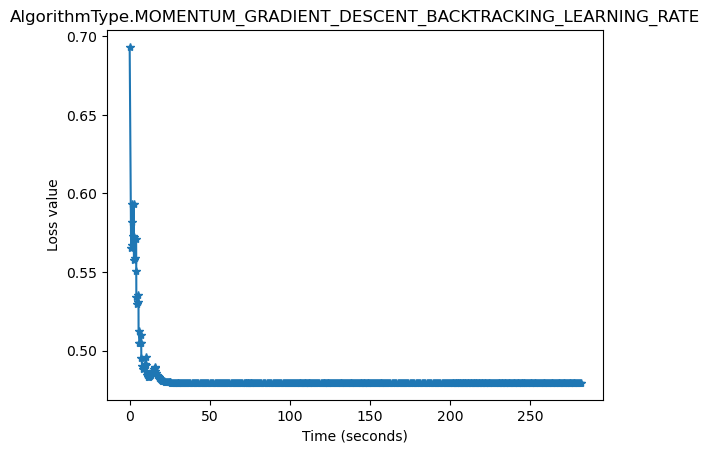

AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Best loss function value: 0.473853
Initial learning rate: 1
Additional parameters: {'gamma': 0.9, 'alpha': 0.3, 'beta': 0.5}
Runtime: 84.343829 s


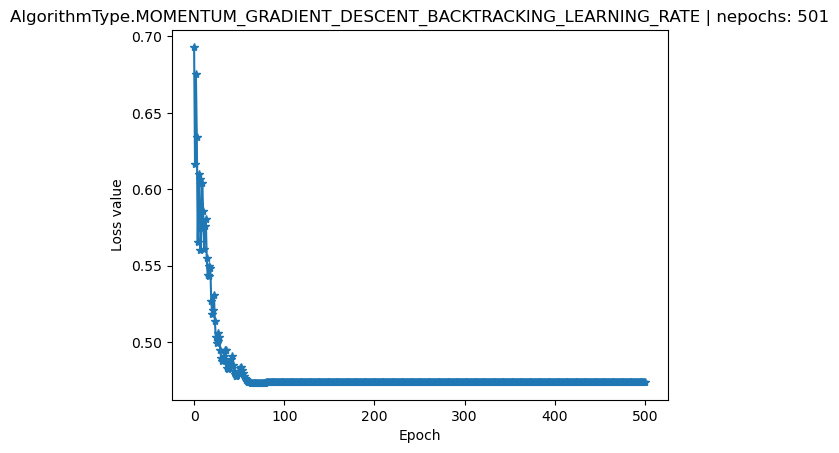

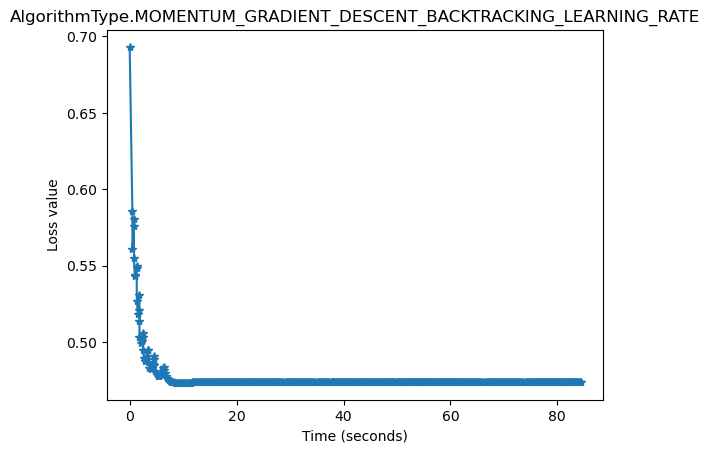

AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Best loss function value: 0.502385
Initial learning rate: 1.5
Additional parameters: {'gamma': 0.9, 'alpha': 0.3, 'beta': 0.5}
Runtime: 92.739648 s


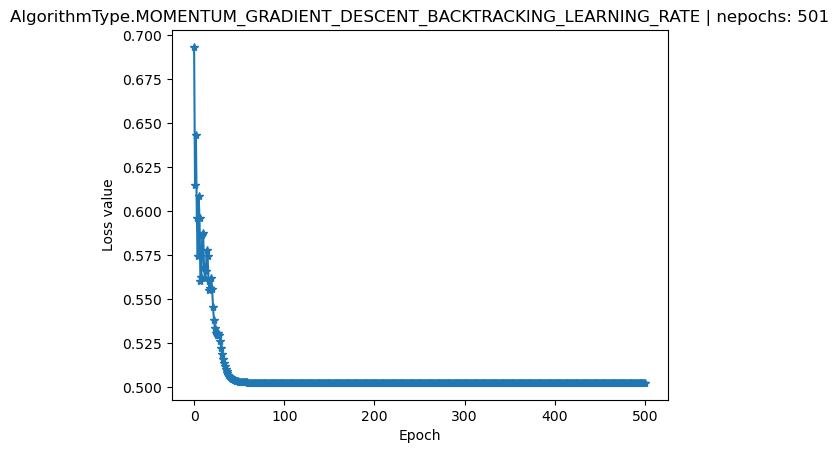

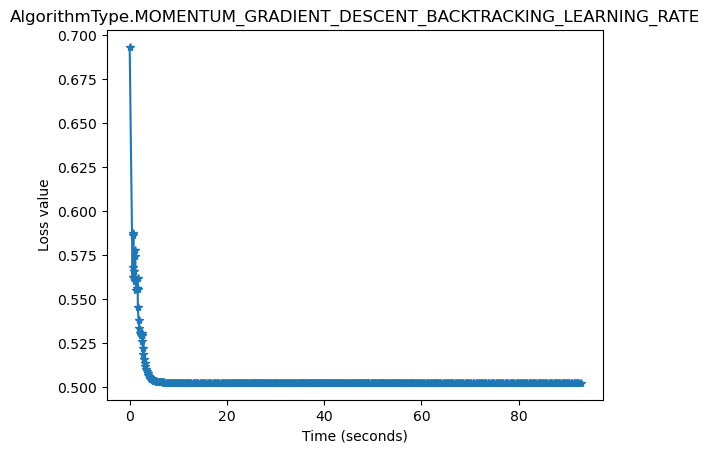

KeyboardInterrupt: 

In [70]:
ALGORITHM_TYPE = AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = [1,1.5]
MAX_EPOCHS = 500
EPS = 1e-6

GAMMA = 0.9
ALPHA = [0.3, 0.1, 0.5]
BETA = [0.8, 0.5]

for a in ALPHA:
    for b in BETA:
        for lr in INITIAL_LEARNING_RATE:

            # ADDITIONAL PARAMETERS
            ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

            ADDITIONAL_PARAMETERS["gamma"] = GAMMA
            ADDITIONAL_PARAMETERS["alpha"] = a
            ADDITIONAL_PARAMETERS["beta"] = b

            (
                MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w,
                MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE__loss_value,
                MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_time_array,
                MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w_tith_time,
            ) = one_for_all(
                algorithm_type=ALGORITHM_TYPE,
                Xbar=Xbar,
                y=y,
                cost=cost,
                grad=grad,
                initial_w=INITIAL_W,
                initial_learning_rate=lr,
                algorithm_name=ALGORITHM_TYPE,
                max_epochs=MAX_EPOCHS,
                eps=EPS,
                marker="*",
                additional_parameters=ADDITIONAL_PARAMETERS,
            )

### 5.10. NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE

AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.216348
Initial learning rate: 0.5
Additional parameters: {'NAG_gamma': 0.9}
Runtime: 0.874549 s


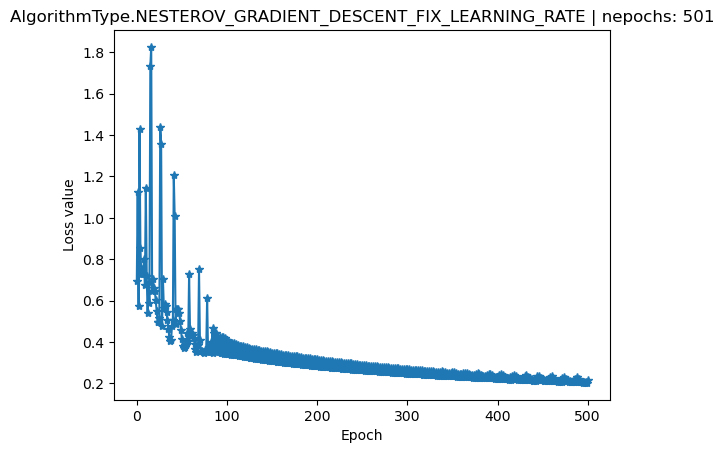

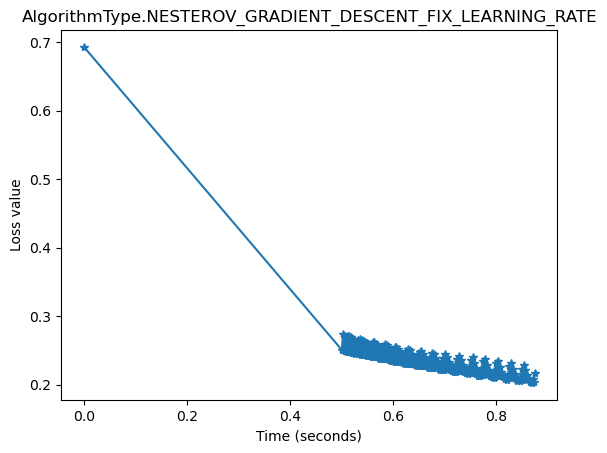

In [96]:
ALGORITHM_TYPE = AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 0.5
MAX_EPOCHS = 500
EPS = 1e-6

GAMMA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["NAG_gamma"] = GAMMA

(
    NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_w,
    NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE__loss_value,
    NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_time_array,
    NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_w_tith_time,
) = one_for_all(
    algorithm_type=ALGORITHM_TYPE,
    Xbar=Xbar,
    y=y,
    cost=cost,
    grad=grad,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    algorithm_name=ALGORITHM_TYPE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    marker="*",
    additional_parameters=ADDITIONAL_PARAMETERS,
)

AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.193818
Initial learning rate: 1
Additional parameters: {'NAG_gamma': 0.9}
Runtime: 0.889154 s


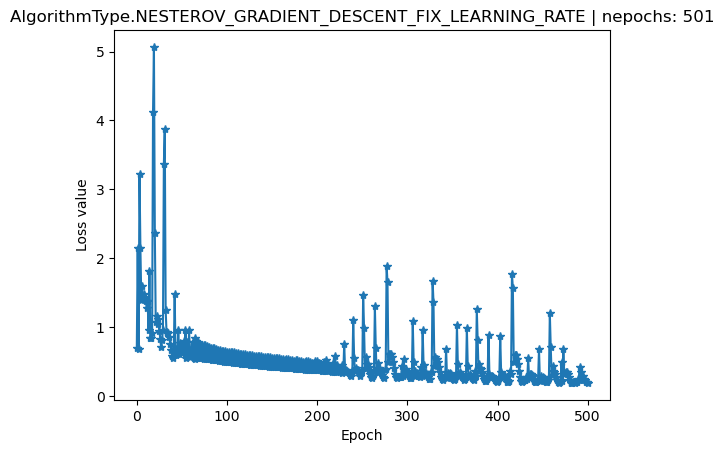

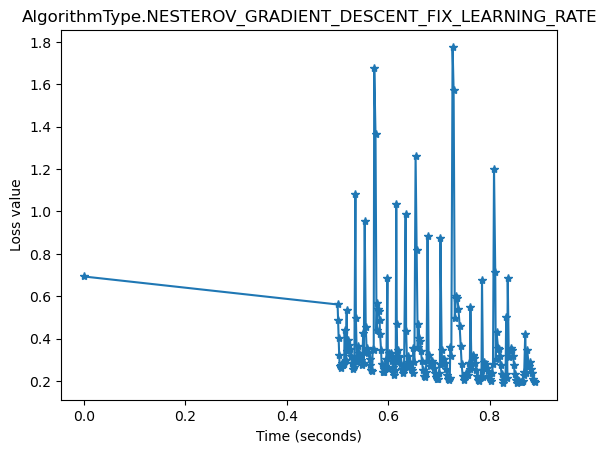

AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.394207
Initial learning rate: 1
Additional parameters: {'NAG_gamma': 0.7}
Runtime: 0.935109 s


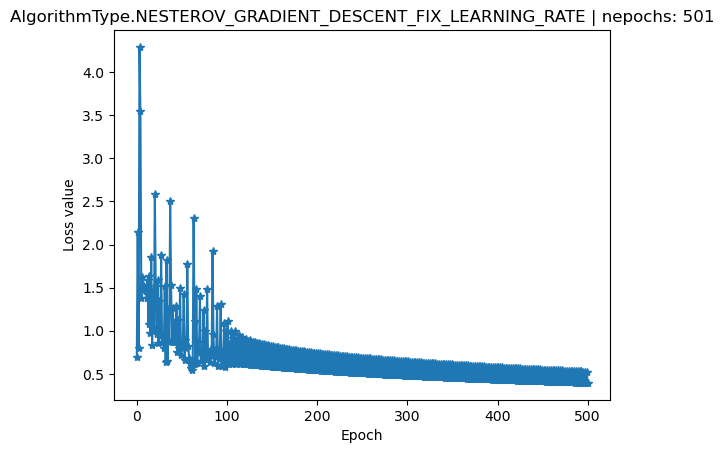

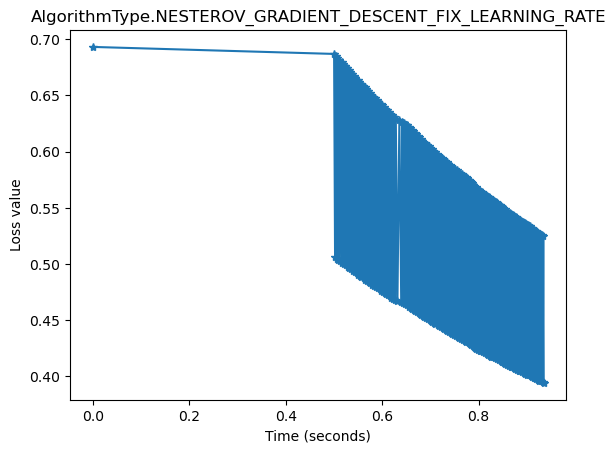

AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.305589
Initial learning rate: 0.1
Additional parameters: {'NAG_gamma': 0.9}
Runtime: 0.983115 s


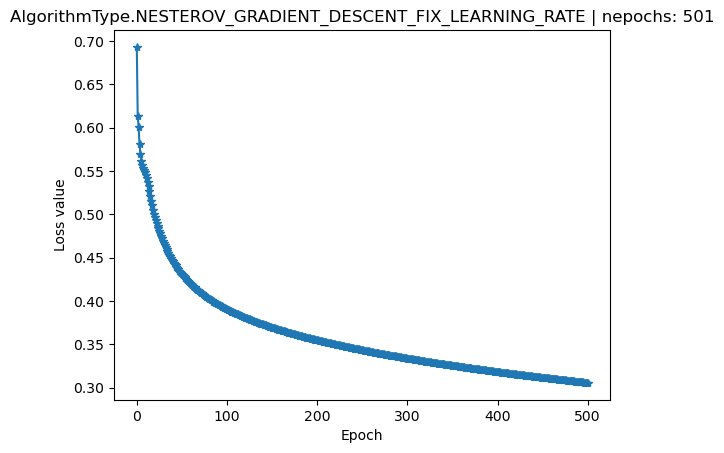

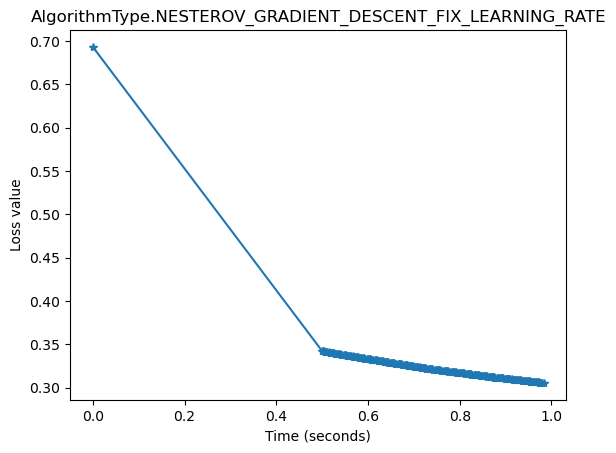

AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.363266
Initial learning rate: 0.1
Additional parameters: {'NAG_gamma': 0.7}
Runtime: 0.974991 s


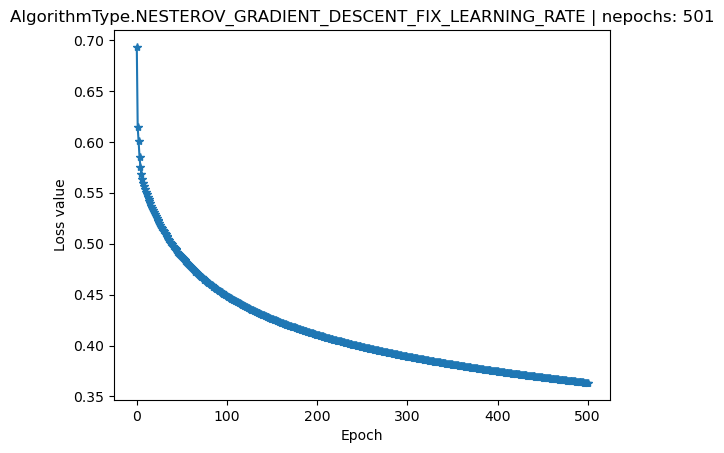

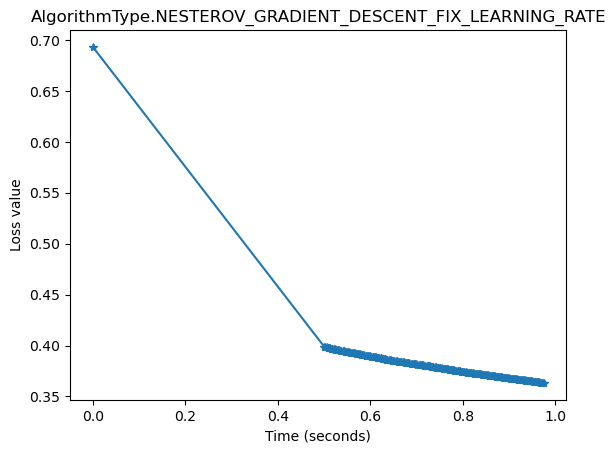

AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.426145
Initial learning rate: 0.01
Additional parameters: {'NAG_gamma': 0.9}
Runtime: 0.952410 s


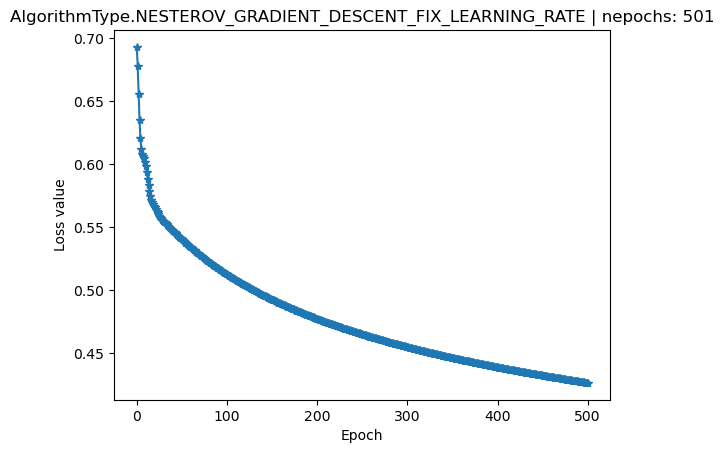

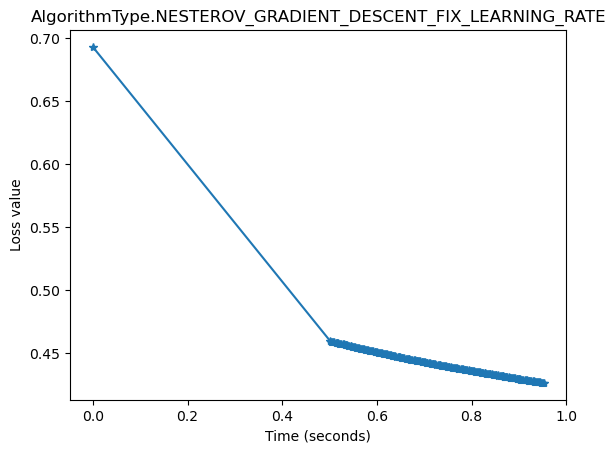

AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.485261
Initial learning rate: 0.01
Additional parameters: {'NAG_gamma': 0.7}
Runtime: 0.925447 s


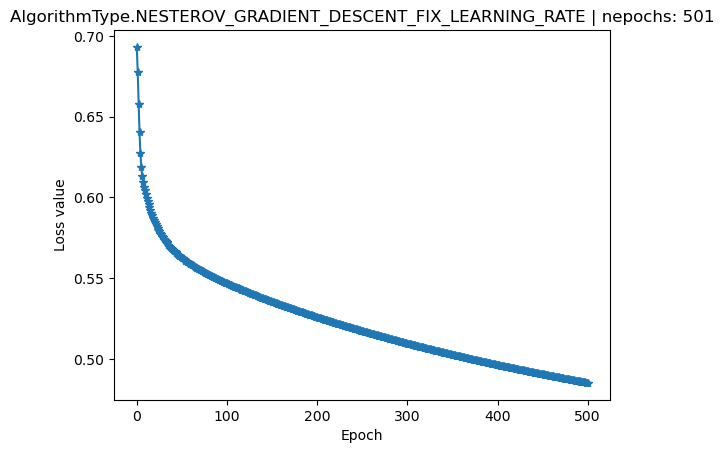

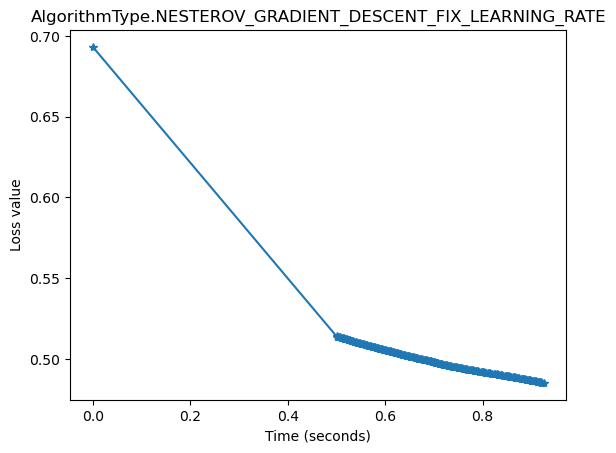

In [86]:
ALGORITHM_TYPE = AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = [1,0.1, 0.01]
MAX_EPOCHS = 500
EPS = 1e-6

GAMMA = [0.9, 0.7]

for lr in INITIAL_LEARNING_RATE:
    for gm in GAMMA:

        # ADDITIONAL PARAMETERS
        ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

        ADDITIONAL_PARAMETERS["NAG_gamma"] = gm

        (
            NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_w,
            NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE__loss_value,
            NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_time_array,
            NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_w_tith_time,
        ) = one_for_all(
            algorithm_type=ALGORITHM_TYPE,
            Xbar=Xbar,
            y=y,
            cost=cost,
            grad=grad,
            initial_w=INITIAL_W,
            initial_learning_rate=lr,
            algorithm_name=ALGORITHM_TYPE,
            max_epochs=MAX_EPOCHS,
            eps=EPS,
            marker="*",
            additional_parameters=ADDITIONAL_PARAMETERS,
        )

### 5.11. NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE

AlgorithmType.NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Best loss function value: 0.568214
Initial learning rate: 0.5
Additional parameters: {'NAG_gamma': 0.8, 'alpha': 0.5, 'beta': 0.8}
Runtime: 33.160383 s


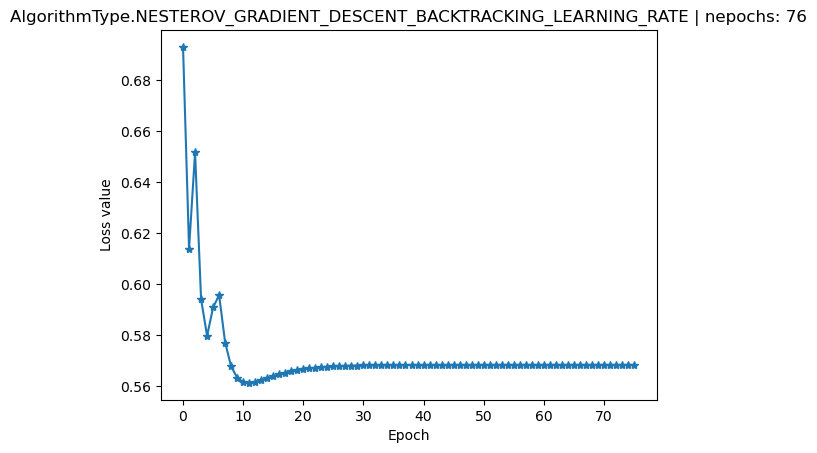

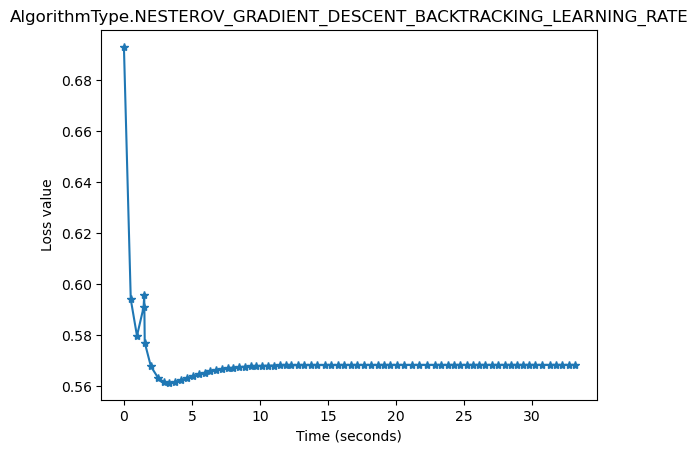

In [101]:
ALGORITHM_TYPE = AlgorithmType.NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 0.5
MAX_EPOCHS = 75
EPS = 1e-6

GAMMA = 0.8
ALPHA = 0.5
BETA = 0.8

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["NAG_gamma"] = GAMMA
ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

(
    NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w,
    NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE__loss_value,
    NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_time_array,
    NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w_tith_time,
) = one_for_all(
    algorithm_type=ALGORITHM_TYPE,
    Xbar=Xbar,
    y=y,
    cost=cost,
    grad=grad,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    algorithm_name=ALGORITHM_TYPE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    marker="*",
    additional_parameters=ADDITIONAL_PARAMETERS,
)

In [ ]:
ALGORITHM_TYPE = AlgorithmType.NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = [1,1.5,0.8]
MAX_EPOCHS = 75
EPS = 1e-6

GAMMA = [0.9, 0.5]
ALPHA = [0.3,0.5]
BETA = [0.8, 0.5]

# ADDITIONAL PARAMETERS
for lr in INITIAL_LEARNING_RATE:
    for gm in GAMMA:
        for a in ALPHA:
            for b in BETA:

                ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

                ADDITIONAL_PARAMETERS["NAG_gamma"] = gm
                ADDITIONAL_PARAMETERS["alpha"] = a
                ADDITIONAL_PARAMETERS["beta"] = b

                (
                    NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w,
                    NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE__loss_value,
                    NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_time_array,
                    NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w_tith_time,
                ) = one_for_all(
                    algorithm_type=ALGORITHM_TYPE,
                    Xbar=Xbar,
                    y=y,
                    cost=cost,
                    grad=grad,
                    initial_w=INITIAL_W,
                    initial_learning_rate=lr,
                    algorithm_name=ALGORITHM_TYPE,
                    max_epochs=MAX_EPOCHS,
                    eps=EPS,
                    marker="*",
                    additional_parameters=ADDITIONAL_PARAMETERS,
                )

## 6. Algorithms comparison

### 6.1. SKLEARN: SGDClassifier | log loss

SGDClassifier(eta0=0.005, learning_rate='constant', loss='log_loss', max_iter=1,
              random_state=42, tol=None, warm_start=True)
Loss value: 0.113883
Runtime: 19.278721 s


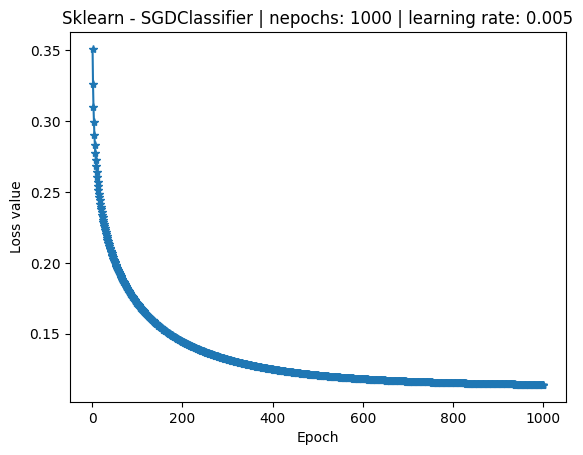

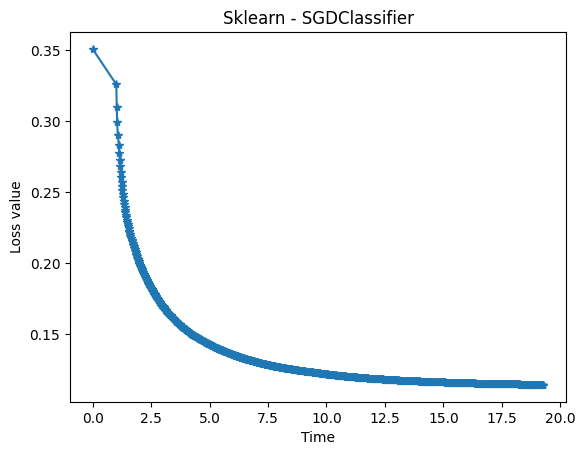

In [251]:
NUMBER_OF_EPOCHS = 1000
INITIAL_LEARNING_RATE = 0.005

X_fit = X.T

sklearn_SGDClassifier_model = SGDClassifier(
    loss="log_loss",
    learning_rate="constant",
    eta0=INITIAL_LEARNING_RATE,
    max_iter=1,
    tol=None,
    random_state=42,
    warm_start=True,
)

sklearn_SGDClassifier_model_time_array_log_loss_values = []

sklearn_SGDClassifier_model_time_array = [0]
start_time = time.time()
time_step = 1

sklearn_SGDClassifier_model_epoch_count = [1]
for epoch in range(1, NUMBER_OF_EPOCHS + 1):  # Train for NUMBER_OF_EPOCHS epochs
    sklearn_SGDClassifier_model.fit(X_fit, y)
    y_prob = sklearn_SGDClassifier_model.predict_proba(X_fit)
    loss = log_loss(y, y_prob)
    sklearn_SGDClassifier_model_time_array_log_loss_values.append(loss)

    current_time = time.time()
    if current_time - start_time >= time_step:
        sklearn_SGDClassifier_model_time_array.append(current_time - start_time)

    sklearn_SGDClassifier_model_epoch_count.append(
        sklearn_SGDClassifier_model_epoch_count[-1] + 1
    )

end_time = time.time()

# Print result
print(f"{sklearn_SGDClassifier_model}")
print(f"Loss value: {sklearn_SGDClassifier_model_time_array_log_loss_values[-1]:.6f}")
print(f"Runtime: {(end_time - start_time):.6f} s")

# Plot loss value along epoch
plt.plot(range(1, NUMBER_OF_EPOCHS + 1), sklearn_SGDClassifier_model_time_array_log_loss_values, marker="*")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.title(
    f"Sklearn - SGDClassifier | nepochs: {NUMBER_OF_EPOCHS} | learning rate: {INITIAL_LEARNING_RATE}"
)
plt.show()

# Plot loss value along time
limit = min(len(sklearn_SGDClassifier_model_time_array), len(sklearn_SGDClassifier_model_time_array_log_loss_values))
plt.plot(sklearn_SGDClassifier_model_time_array[:limit], sklearn_SGDClassifier_model_time_array_log_loss_values[:limit], marker="*")
plt.xlabel("Time")
plt.ylabel("Loss value")
plt.title(f"Sklearn - SGDClassifier")
plt.show()

SGDClassifier(eta0=0.01, learning_rate='constant', loss='log_loss', max_iter=1,
              random_state=42, tol=None, warm_start=True)
Loss value: 0.112774
Runtime: 17.974379 s


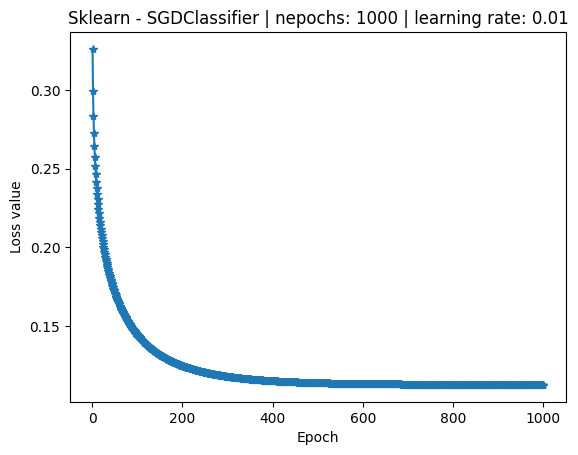

In [152]:
NUMBER_OF_EPOCHS = 1000
INITIAL_LEARNING_RATE = 0.01

X_fit = X.T

sklearn_SGDClassifier_model = SGDClassifier(
    loss="log_loss",
    learning_rate="constant",
    eta0=INITIAL_LEARNING_RATE,
    max_iter=1,
    tol=None,
    random_state=42,
    warm_start=True,
)

log_loss_values = []


start_time = time.time()

for epoch in range(1, NUMBER_OF_EPOCHS + 1):  # Train for NUMBER_OF_EPOCHS epochs
    sklearn_SGDClassifier_model.fit(X_fit, y)
    y_prob = sklearn_SGDClassifier_model.predict_proba(X_fit)
    loss = log_loss(y, y_prob)
    log_loss_values.append(loss)

end_time = time.time()

# Print result
print(f"{sklearn_SGDClassifier_model}")
print(f"Loss value: {log_loss_values[-1]:.6f}")
print(f"Runtime: {(end_time - start_time):.6f} s")

# Plot the loss curve
plt.plot(range(1, NUMBER_OF_EPOCHS + 1), log_loss_values, marker="*")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.title(
    f"Sklearn - SGDClassifier | nepochs: {NUMBER_OF_EPOCHS} | learning rate: {INITIAL_LEARNING_RATE}"
)
plt.show()

SGDClassifier(eta0=0.02, learning_rate='constant', loss='log_loss', max_iter=1,
              random_state=42, tol=None, warm_start=True)
Loss value: 0.113111
Runtime: 17.805003 s


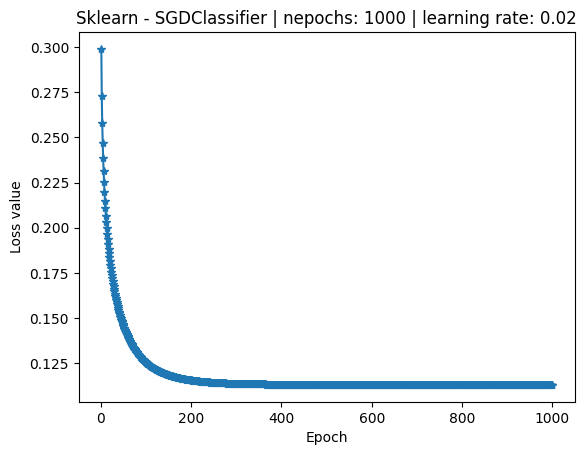

In [153]:
NUMBER_OF_EPOCHS = 1000
INITIAL_LEARNING_RATE = 0.02

X_fit = X.T

sklearn_SGDClassifier_model = SGDClassifier(
    loss="log_loss",
    learning_rate="constant",
    eta0=INITIAL_LEARNING_RATE,
    max_iter=1,
    tol=None,
    random_state=42,
    warm_start=True,
)

log_loss_values = []


start_time = time.time()

for epoch in range(1, NUMBER_OF_EPOCHS + 1):  # Train for NUMBER_OF_EPOCHS epochs
    sklearn_SGDClassifier_model.fit(X_fit, y)
    y_prob = sklearn_SGDClassifier_model.predict_proba(X_fit)
    loss = log_loss(y, y_prob)
    log_loss_values.append(loss)

end_time = time.time()

# Print result
print(f"{sklearn_SGDClassifier_model}")
print(f"Loss value: {log_loss_values[-1]:.6f}")
print(f"Runtime: {(end_time - start_time):.6f} s")

# Plot the loss curve
plt.plot(range(1, NUMBER_OF_EPOCHS + 1), log_loss_values, marker="*")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.title(
    f"Sklearn - SGDClassifier | nepochs: {NUMBER_OF_EPOCHS} | learning rate: {INITIAL_LEARNING_RATE}"
)
plt.show()

SGDClassifier(eta0=0.05, learning_rate='constant', loss='log_loss', max_iter=1,
              random_state=42, tol=None, warm_start=True)
Loss value: 0.119425
Runtime: 17.801031 s


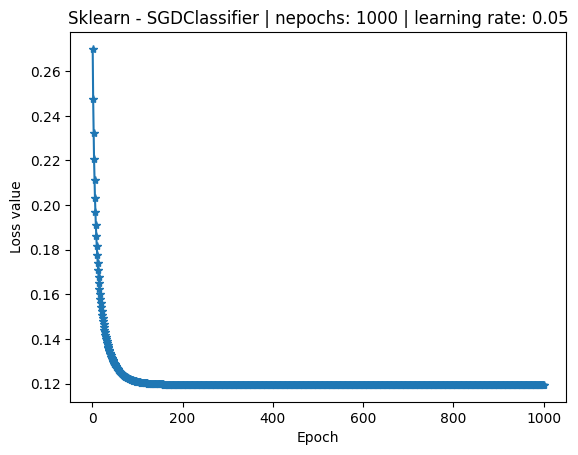

In [154]:
NUMBER_OF_EPOCHS = 1000
INITIAL_LEARNING_RATE = 0.05

X_fit = X.T

sklearn_SGDClassifier_model = SGDClassifier(
    loss="log_loss",
    learning_rate="constant",
    eta0=INITIAL_LEARNING_RATE,
    max_iter=1,
    tol=None,
    random_state=42,
    warm_start=True,
)

log_loss_values = []


start_time = time.time()

for epoch in range(1, NUMBER_OF_EPOCHS + 1):  # Train for NUMBER_OF_EPOCHS epochs
    sklearn_SGDClassifier_model.fit(X_fit, y)
    y_prob = sklearn_SGDClassifier_model.predict_proba(X_fit)
    loss = log_loss(y, y_prob)
    log_loss_values.append(loss)

end_time = time.time()

# Print result
print(f"{sklearn_SGDClassifier_model}")
print(f"Loss value: {log_loss_values[-1]:.6f}")
print(f"Runtime: {(end_time - start_time):.6f} s")

# Plot the loss curve
plt.plot(range(1, NUMBER_OF_EPOCHS + 1), log_loss_values, marker="*")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.title(
    f"Sklearn - SGDClassifier | nepochs: {NUMBER_OF_EPOCHS} | learning rate: {INITIAL_LEARNING_RATE}"
)
plt.show()

SGDClassifier(eta0=0.1, learning_rate='constant', loss='log_loss', max_iter=1,
              random_state=42, tol=None, warm_start=True)
Loss value: 0.125859
Runtime: 17.848480 s


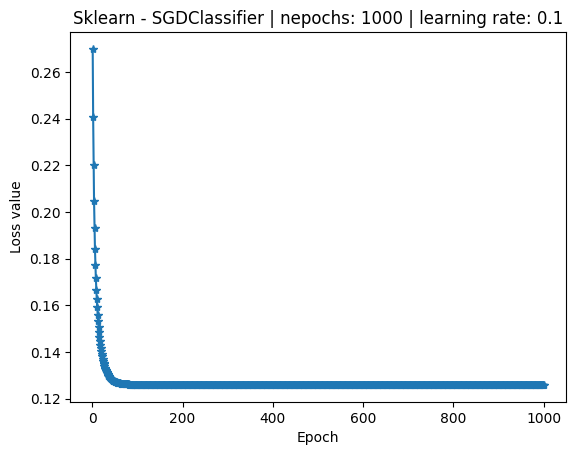

In [155]:
NUMBER_OF_EPOCHS = 1000
INITIAL_LEARNING_RATE = 0.1

X_fit = X.T

sklearn_SGDClassifier_model = SGDClassifier(
    loss="log_loss",
    learning_rate="constant",
    eta0=INITIAL_LEARNING_RATE,
    max_iter=1,
    tol=None,
    random_state=42,
    warm_start=True,
)

log_loss_values = []


start_time = time.time()

for epoch in range(1, NUMBER_OF_EPOCHS + 1):  # Train for NUMBER_OF_EPOCHS epochs
    sklearn_SGDClassifier_model.fit(X_fit, y)
    y_prob = sklearn_SGDClassifier_model.predict_proba(X_fit)
    loss = log_loss(y, y_prob)
    log_loss_values.append(loss)

end_time = time.time()

# Print result
print(f"{sklearn_SGDClassifier_model}")
print(f"Loss value: {log_loss_values[-1]:.6f}")
print(f"Runtime: {(end_time - start_time):.6f} s")

# Plot the loss curve
plt.plot(range(1, NUMBER_OF_EPOCHS + 1), log_loss_values, marker="*")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.title(
    f"Sklearn - SGDClassifier | nepochs: {NUMBER_OF_EPOCHS} | learning rate: {INITIAL_LEARNING_RATE}"
)
plt.show()

### 6.2. Best of algorithms

#### 6.2.1. Best GRADIENT_DESCENT_FIX_LEARNING_RATE

GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.236563
Initial learning rate: 0.5
Additional parameters: None
Runtime: 1.415622 s


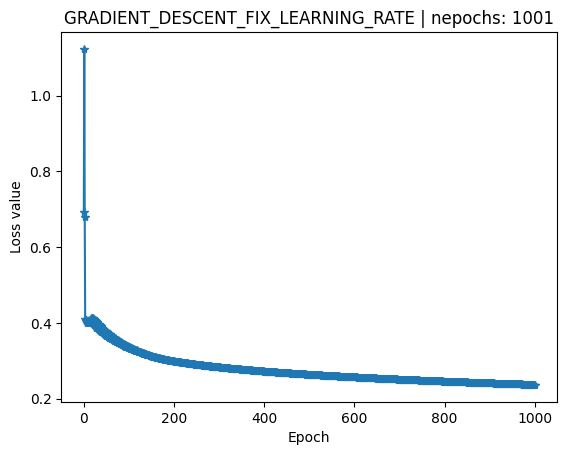

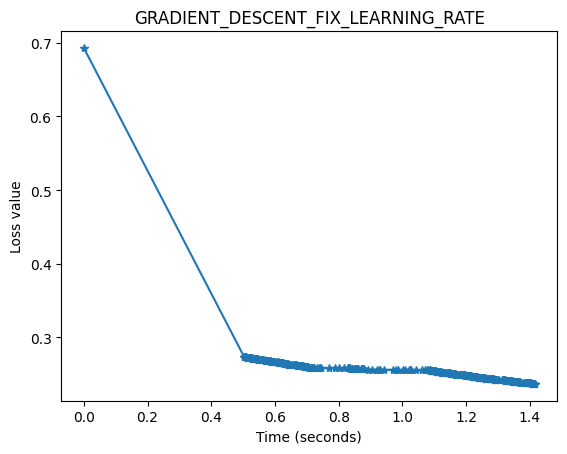

In [224]:
ALGORITHM_TYPE = AlgorithmType.GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 0.5
MAX_EPOCHS = 1000
EPS = 1e-6


# ADDITIONAL PARAMETERS
ALGORITHM_TYPE.value

(
    GRADIENT_DESCENT_FIX_LEARNING_RATE_w,
    GRADIENT_DESCENT_FIX_LEARNING_RATE_loss_value,
    GRADIENT_DESCENT_FIX_LEARNING_RATE_time_array,
    GRADIENT_DESCENT_FIX_LEARNING_RATE_epoch_count,
) = one_for_all(
    algorithm_type=ALGORITHM_TYPE,
    Xbar=Xbar,
    y=y,
    cost=cost,
    grad=grad,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    algorithm_name=ALGORITHM_TYPE.name,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    marker="*",
)

#### 6.2.2. Best GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE

GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Best loss function value: 0.404693
Initial learning rate: 1
Additional parameters: {'alpha': 0.1, 'beta': 0.7}
Runtime: 64.607088 s


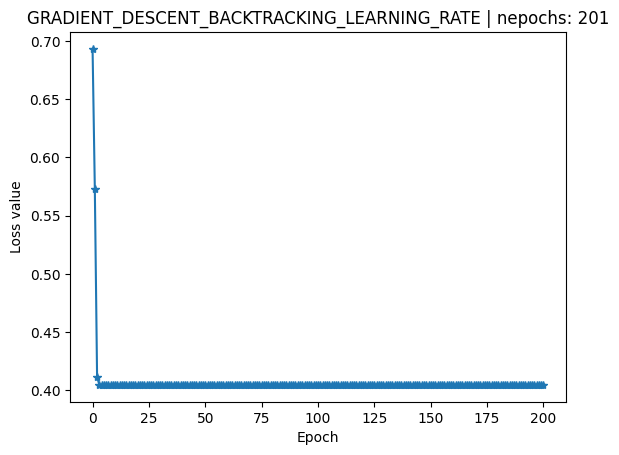

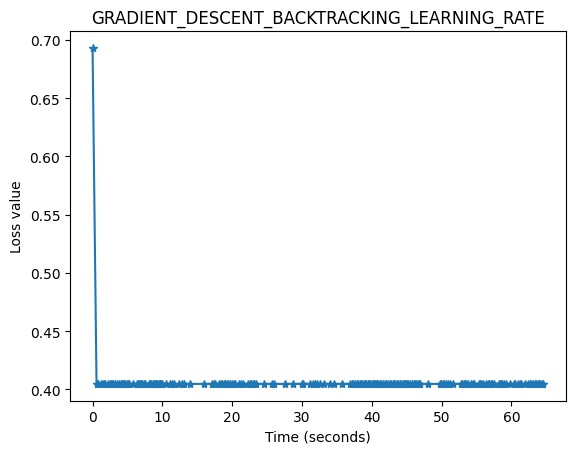

In [226]:
ALGORITHM_TYPE = AlgorithmType.GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 200
EPS = 1e-6

ALPHA = 0.1
BETA = 0.7


# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

(
    GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w,
    GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_loss_value,
    GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_time_array,
    GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_epoch_count,
) = one_for_all(
    algorithm_type=ALGORITHM_TYPE,
    Xbar=Xbar,
    y=y,
    cost=cost,
    grad=grad,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    algorithm_name=ALGORITHM_TYPE.name,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    marker="*",
    additional_parameters=ADDITIONAL_PARAMETERS,
)

#### 6.2.3. Best STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE

AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.029728
Initial learning rate: 0.03
Additional parameters: {'batch_size': 1, 'rule': 0, 'random_seed': 10}
Runtime: 107.245334 s


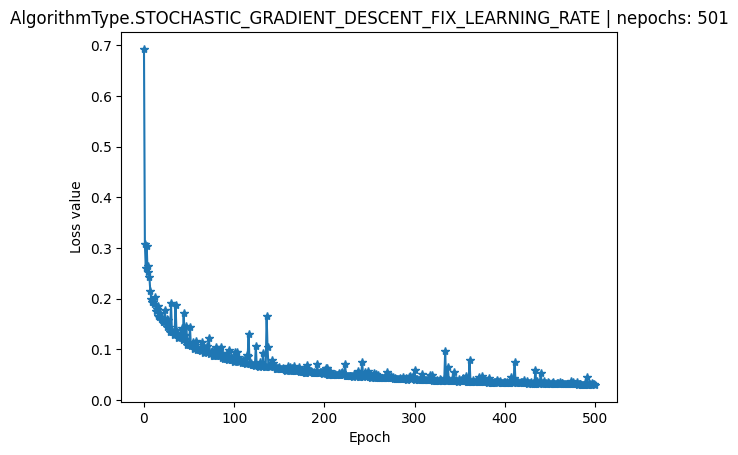

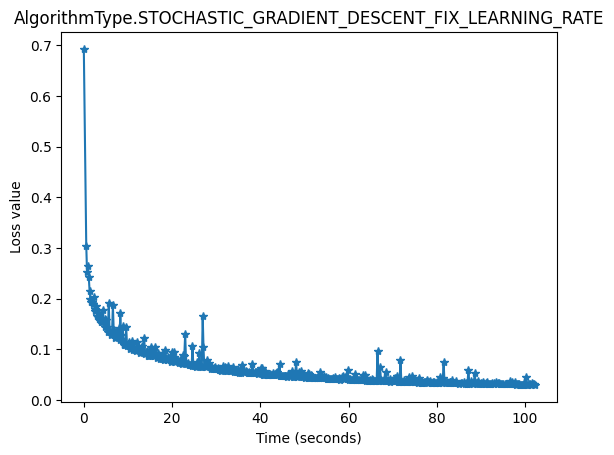

In [227]:
ALGORITHM_TYPE = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 0.03
MAX_EPOCHS = 500
EPS = 1e-6

BATCH_SIZE = 1
RULE = 0
RANDOM_SEED = 10


# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED

(
    STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_w,
    STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_loss_value,
    STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_time_array,
    STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_epoch_count,
) = one_for_all(
    algorithm_type=ALGORITHM_TYPE,
    Xbar=Xbar,
    y=y,
    cost=cost,
    grad=grad,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    algorithm_name=ALGORITHM_TYPE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    marker="*",
    additional_parameters=ADDITIONAL_PARAMETERS,
)

#### 6.2.4. Best MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE

AlgorithmType.MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.127803
Initial learning rate: 1
Additional parameters: {'gamma': 0.9}
Runtime: 1.821656 s


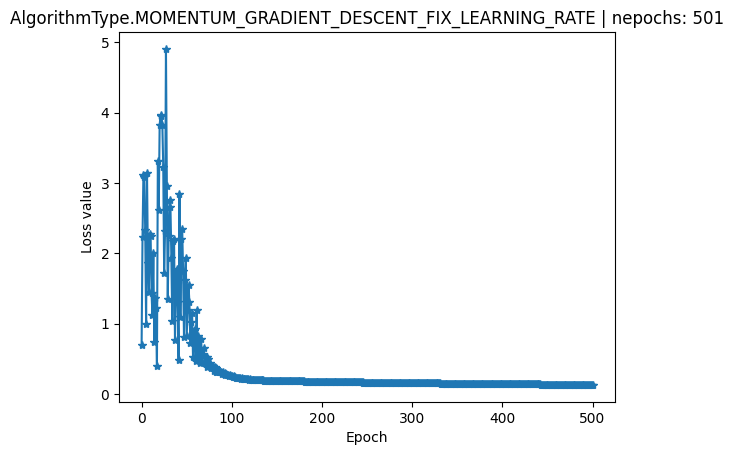

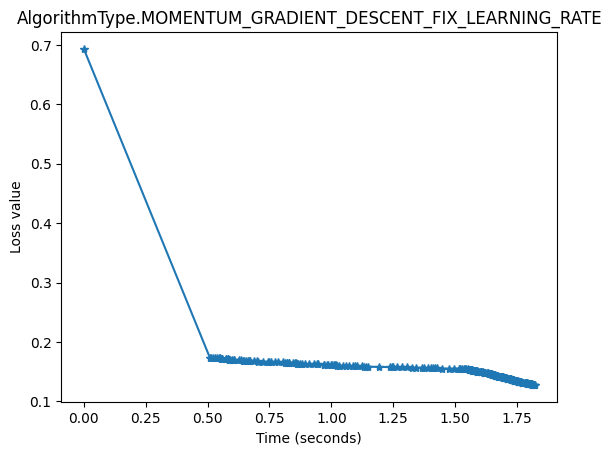

In [276]:
ALGORITHM_TYPE = AlgorithmType.MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 500
EPS = 1e-6

GAMMA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["gamma"] = GAMMA

(
    MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_w,
    MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_loss_value,
    MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_time_array,
    MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_epoch_count,
) = one_for_all(
    algorithm_type=ALGORITHM_TYPE,
    Xbar=Xbar,
    y=y,
    cost=cost,
    grad=grad,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    algorithm_name=ALGORITHM_TYPE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    marker="*",
    additional_parameters=ADDITIONAL_PARAMETERS,
)

#### 6.2.5. Best MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE

AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Best loss function value: 0.319301
Initial learning rate: 1
Additional parameters: {'gamma': 0.9, 'alpha': 0.3, 'beta': 0.5}
Runtime: 109.599962 s


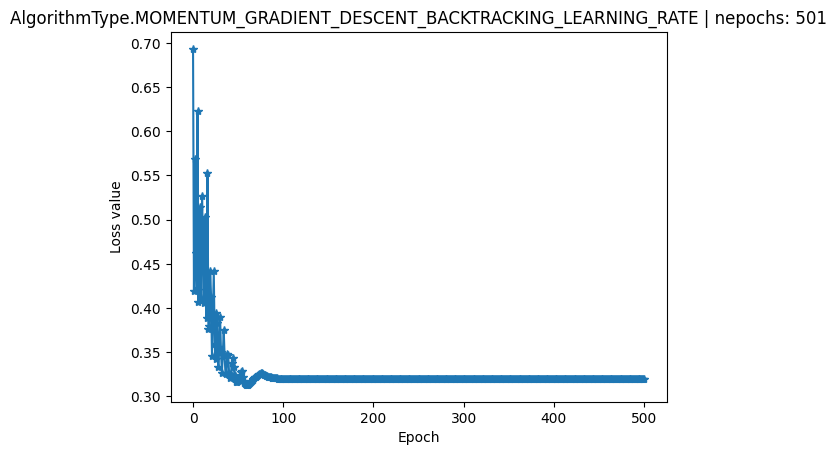

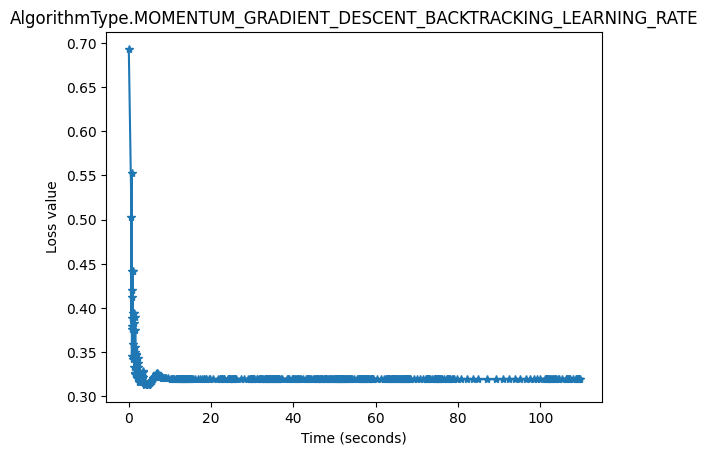

In [266]:
ALGORITHM_TYPE = AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 500
EPS = 1e-6

GAMMA = 0.9
ALPHA = 0.3
BETA = 0.5

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["gamma"] = GAMMA
ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

(
    MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w,
    MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_loss_value,
    MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_time_array,
    MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_epoch_count,
) = one_for_all(
    algorithm_type=ALGORITHM_TYPE,
    Xbar=Xbar,
    y=y,
    cost=cost,
    grad=grad,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    algorithm_name=ALGORITHM_TYPE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    marker="*",
    additional_parameters=ADDITIONAL_PARAMETERS,
)

#### 6.2.6. Best NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE

AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss function value: 0.163301
Initial learning rate: 0.5
Additional parameters: {'NAG_gamma': 0.9}
Runtime: 1.387785 s


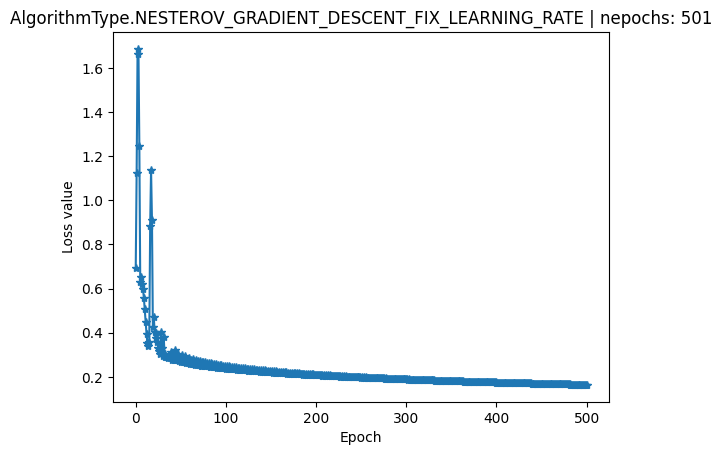

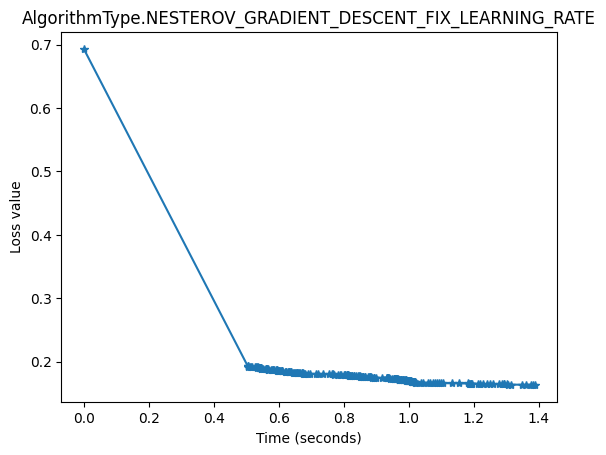

In [285]:
ALGORITHM_TYPE = AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 0.5
MAX_EPOCHS = 500
EPS = 1e-6

GAMMA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["NAG_gamma"] = GAMMA

(
    NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_w,
    NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_loss_value,
    NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_time_array,
    NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_epoch_count,
) = one_for_all(
    algorithm_type=ALGORITHM_TYPE,
    Xbar=Xbar,
    y=y,
    cost=cost,
    grad=grad,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    algorithm_name=ALGORITHM_TYPE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    marker="*",
    additional_parameters=ADDITIONAL_PARAMETERS,
)

#### 6.2.7. Best NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE

AlgorithmType.NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Best loss function value: 0.288114
Initial learning rate: 0.5
Additional parameters: {'NAG_gamma': 0.9, 'alpha': 0.1, 'beta': 0.8}
Runtime: 19.484836 s


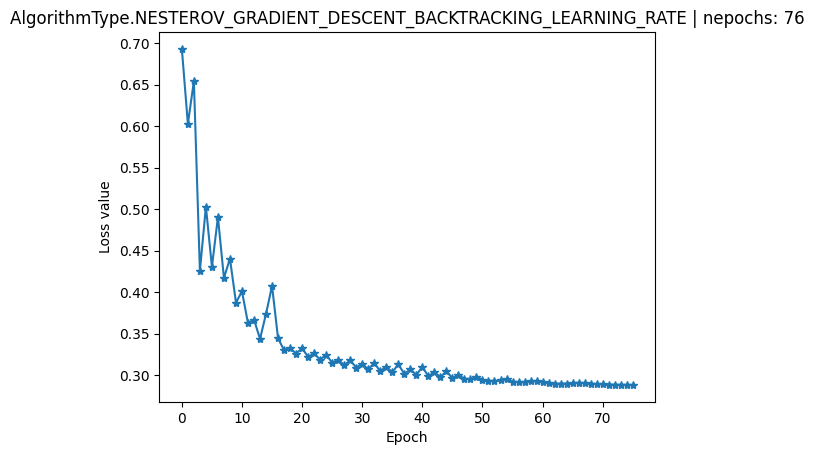

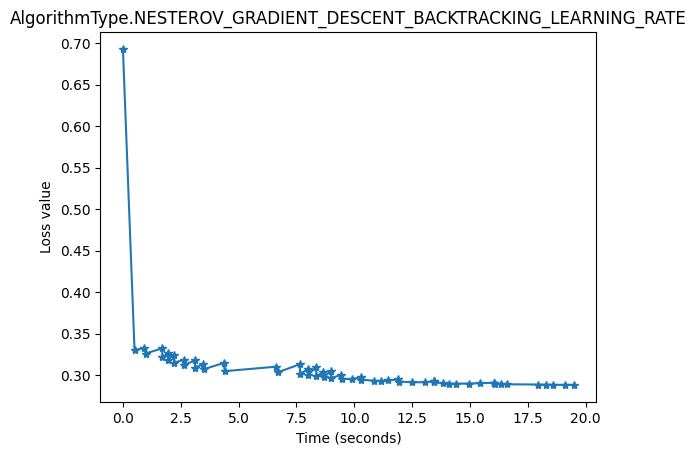

In [267]:
ALGORITHM_TYPE = AlgorithmType.NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 0.5
MAX_EPOCHS = 75
EPS = 1e-6

GAMMA = 0.9
ALPHA = 0.1
BETA = 0.8

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["NAG_gamma"] = GAMMA
ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

(
    NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w,
    NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_loss_value,
    NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_time_array,
    NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_epoch_count,
) = one_for_all(
    algorithm_type=ALGORITHM_TYPE,
    Xbar=Xbar,
    y=y,
    cost=cost,
    grad=grad,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    algorithm_name=ALGORITHM_TYPE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    marker="*",
    additional_parameters=ADDITIONAL_PARAMETERS,
)

### 6.3. Build Comparer

In [183]:
class AlgorithmPlot:
    def __init__(
        self, name: str, epoch_count: list, time_array: list, loss_values: list
    ):
        self.name = name
        self.epoch_count = epoch_count
        self.time_array = time_array
        self.loss_values = loss_values

In [260]:
def plot_algorithm_in_a_plot(
    algorithm_plots: list[AlgorithmPlot],
):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Epoch

    for algorithm in algorithm_plots:
        limit = min(len(algorithm.epoch_count), len(algorithm.loss_values))
        axs[0].plot(
            algorithm.epoch_count[:limit],
            algorithm.loss_values[:limit],
            label=f"Best {algorithm.name}",
        )

    axs[0].legend()
    axs[0].set_title("Loss value according epochs")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss value")

    for algorithm in algorithm_plots:
        limit = min(len(algorithm.time_array), len(algorithm.loss_values))
        axs[1].plot(
            algorithm.time_array[:limit],
            algorithm.loss_values[:limit],
            label=f"Best {algorithm.name}",
        )

    axs[1].legend()
    axs[1].set_title("Loss value according time")
    axs[1].set_xlabel("Time (seconds)")
    axs[1].set_ylabel("Loss value")

    plt.show()

### 6.4. Comparisons

In [286]:
algorithm_plots = []

In [287]:
SKLEARN_SGD_plot = AlgorithmPlot(
    name="SKLEARN_SGD",
    epoch_count=sklearn_SGDClassifier_model_epoch_count,
    time_array=sklearn_SGDClassifier_model_time_array,
    loss_values=sklearn_SGDClassifier_model_time_array_log_loss_values,
)

algorithm_plots.append(SKLEARN_SGD_plot)

In [288]:
GRADIENT_DESCENT_FIX_LEARNING_RATE_plot = AlgorithmPlot(
    name="GD_FIX",
    epoch_count=GRADIENT_DESCENT_FIX_LEARNING_RATE_epoch_count,
    time_array=GRADIENT_DESCENT_FIX_LEARNING_RATE_time_array,
    loss_values=GRADIENT_DESCENT_FIX_LEARNING_RATE_loss_value,
)

algorithm_plots.append(GRADIENT_DESCENT_FIX_LEARNING_RATE_plot)

In [289]:
GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_plot = AlgorithmPlot(
    name="GD_BACKTRACKING",
    epoch_count=GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_epoch_count,
    time_array=GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_time_array,
    loss_values=GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_loss_value,
)

algorithm_plots.append(GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_plot)

In [290]:
STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_plot = AlgorithmPlot(
    name="SGD_FIX",
    epoch_count=STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_epoch_count,
    time_array=STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_time_array,
    loss_values=STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_loss_value,
)

algorithm_plots.append(STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_plot)

In [291]:
MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_plot = AlgorithmPlot(
    name="MOMENTUM_FIX",
    epoch_count=MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_epoch_count,
    time_array=MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_time_array,
    loss_values=MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_loss_value,
)

algorithm_plots.append(MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_plot)

In [292]:
MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_plot = AlgorithmPlot(
    name="MOMENTUM_BACKTRACKING",
    epoch_count=MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_epoch_count,
    time_array=MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_time_array,
    loss_values=MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_loss_value,
)

algorithm_plots.append(MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_plot)

In [293]:
NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_plot = AlgorithmPlot(
    name="NESTEROV_FIX",
    epoch_count=NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_epoch_count,
    time_array=NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_time_array,
    loss_values=NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_loss_value,
)

algorithm_plots.append(NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_plot)

In [294]:
NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_plot = AlgorithmPlot(
    name="NESTEROV_BACKTRACKING",
    epoch_count=NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_epoch_count,
    time_array=NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_time_array,
    loss_values=NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_loss_value,
)

algorithm_plots.append(NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_plot)

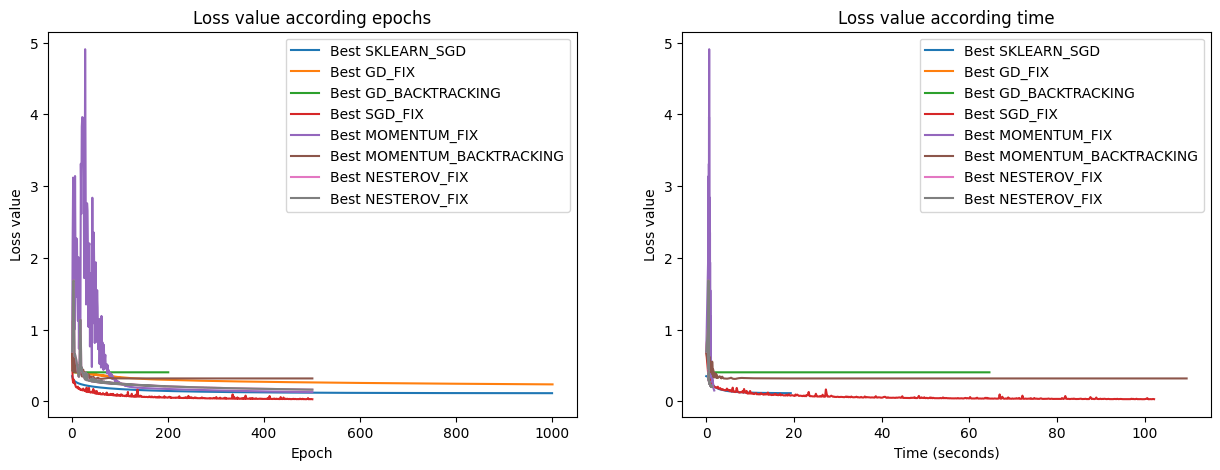

In [295]:
plot_algorithm_in_a_plot(algorithm_plots)

## 7. Conclusion